# CNN + GlobalAvgPool 
Non-coding RNA 1-2K.   
Loop over all cell lines, one at a time.

Conv1d + GlobalAvgPool1d + Dense(1).

This model did not just predict the majority class. In some runs it was overfitting. In others it was still improving.  

In [16]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-01-03 13:23:23.948123
Python 3.8.16
sklearn 1.0.2


In [17]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Flatten
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=16
DCELLS=8
EPOCHS=5
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=1000
MAXLEN=2000   

In [18]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [19]:
GENES_FILE =    'CNRCI_noncoding_train_genes.csv'
RCI_FILE =      'CNRCI_noncoding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_noncoding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_noncoding_train_counts.K4.gc42.csv'

In [20]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [21]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq

## Model

In [22]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    #pool_layer = MaxPooling1D(pool_size=3)
    pool_layer = GlobalAveragePooling1D()
    #pool_layer = GlobalMaxPooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(pool_layer)
    #rnn.add(flat_layer)
    #rnn.add(den1_layer)
    #rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [23]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2023-01-03 13:23:24.998521
COMPILE
Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_76 (Embedding)    (None, 1997, 4)           1028      
                                                                 
 conv1d_76 (Conv1D)          (None, 1990, 64)          2112      
                                                                 
 global_average_pooling1d_76  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_153 (Dense)           (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [24]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

## Driver

-------------
2023-01-03 13:23:25.124586
Cell line for today: 0 = A549
Load RCI values...
Num RCI: 1447
Load genes...
2023-01-03 13:23:25.139210
Load sequence...
2023-01-03 13:23:27.352807
Num IDs: 2994
Count 1548 ones out of 2994 labels.
Num counts: 2994
2023-01-03 13:23:27.355434
splitting
Fold 1
Training example
[ 14  53 211 ...   0   0   0]
Train sizes (2394, 1997) (2394, 1)
Valid sizes (600, 1997) (600, 1)
Train set ones/size 1176 / 2394
Valid set ones/size 372 / 600
BUILD MODEL
COMPILE
FIT
2023-01-03 13:23:27.763077
Epoch 1/5
75/75 [==============================] - 1s 9ms/step - loss: 0.6927 - accuracy: 0.5038 - val_loss: 0.7062 - val_accuracy: 0.3800
Epoch 2/5
75/75 [==============================] - 0s 6ms/step - loss: 0.6835 - accuracy: 0.5727 - val_loss: 0.7086 - val_accuracy: 0.4700
Epoch 3/5
75/75 [==============================] - 0s 6ms/step - loss: 0.6519 - accuracy: 0.6195 - val_loss: 0.7318 - val_accuracy: 0.5250
Epoch 4/5
75/75 [==============================] - 0s 6

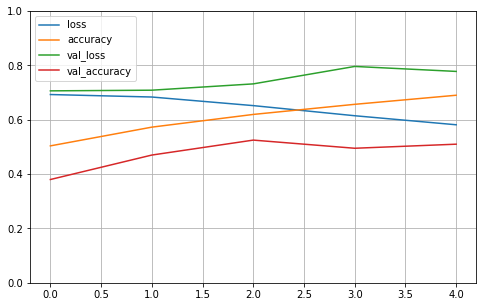

Compute valiation accuracy
2023-01-03 13:23:31.045992
Range of scores: 0.035001937 to 0.95080477
Predicted zeros and ones 236 364
Accuracy: 51.00% Precision: 60.71% Recall: 59.41% F1: 60.05%
2023-01-03 13:23:31.208685
Fold 2
Training example
[211  74  38 ...   0   0   0]
Train sizes (2425, 1997) (2425, 1)
Valid sizes (569, 1997) (569, 1)
Train set ones/size 1288 / 2425
Valid set ones/size 260 / 569
BUILD MODEL
COMPILE
FIT
2023-01-03 13:23:31.647175
Epoch 1/5
76/76 [==============================] - 1s 8ms/step - loss: 0.6915 - accuracy: 0.5184 - val_loss: 0.7027 - val_accuracy: 0.4569
Epoch 2/5
76/76 [==============================] - 0s 6ms/step - loss: 0.6863 - accuracy: 0.5398 - val_loss: 0.6943 - val_accuracy: 0.4745
Epoch 3/5
76/76 [==============================] - 0s 6ms/step - loss: 0.6728 - accuracy: 0.5988 - val_loss: 0.7228 - val_accuracy: 0.4815
Epoch 4/5
76/76 [==============================] - 0s 6ms/step - loss: 0.6505 - accuracy: 0.6219 - val_loss: 0.6904 - val_accuracy

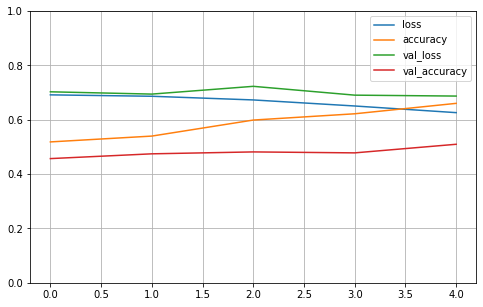

Compute valiation accuracy
2023-01-03 13:23:34.960260
Range of scores: 0.10327218 to 0.78930193
Predicted zeros and ones 220 349
Accuracy: 50.97% Precision: 47.28% Recall: 63.46% F1: 54.19%
2023-01-03 13:23:35.116353
Fold 3
Training example
[211  74  38 ...   0   0   0]
Train sizes (2538, 1997) (2538, 1)
Valid sizes (456, 1997) (456, 1)
Train set ones/size 1276 / 2538
Valid set ones/size 272 / 456
BUILD MODEL
COMPILE
FIT
2023-01-03 13:23:35.533613
Epoch 1/5
80/80 [==============================] - 1s 8ms/step - loss: 0.6931 - accuracy: 0.4894 - val_loss: 0.6906 - val_accuracy: 0.6140
Epoch 2/5
80/80 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5634 - val_loss: 0.6849 - val_accuracy: 0.5965
Epoch 3/5
80/80 [==============================] - 0s 6ms/step - loss: 0.6568 - accuracy: 0.6210 - val_loss: 0.7534 - val_accuracy: 0.4276
Epoch 4/5
80/80 [==============================] - 0s 6ms/step - loss: 0.6192 - accuracy: 0.6580 - val_loss: 0.7404 - val_accuracy:

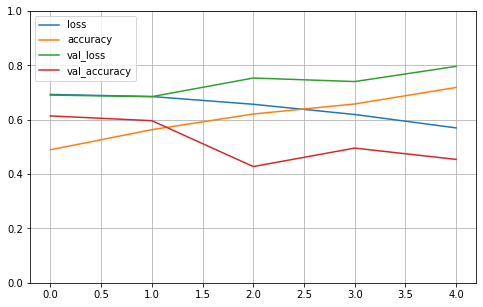

Compute valiation accuracy
2023-01-03 13:23:41.376334
Range of scores: 0.09005658 to 0.91446054
Predicted zeros and ones 233 223
Accuracy: 45.39% Precision: 55.16% Recall: 45.22% F1: 49.70%
2023-01-03 13:23:41.526647
Fold 4
Training example
[211  74  38 ...   0   0   0]
Train sizes (2094, 1997) (2094, 1)
Valid sizes (900, 1997) (900, 1)
Train set ones/size 1188 / 2094
Valid set ones/size 360 / 900
BUILD MODEL
COMPILE
FIT
2023-01-03 13:23:41.944911
Epoch 1/5
66/66 [==============================] - 1s 10ms/step - loss: 0.6843 - accuracy: 0.5578 - val_loss: 0.7578 - val_accuracy: 0.4000
Epoch 2/5
66/66 [==============================] - 0s 7ms/step - loss: 0.6827 - accuracy: 0.5673 - val_loss: 0.7145 - val_accuracy: 0.4000
Epoch 3/5
66/66 [==============================] - 0s 6ms/step - loss: 0.6817 - accuracy: 0.5669 - val_loss: 0.7117 - val_accuracy: 0.4056
Epoch 4/5
66/66 [==============================] - 0s 8ms/step - loss: 0.6774 - accuracy: 0.5683 - val_loss: 0.7139 - val_accuracy

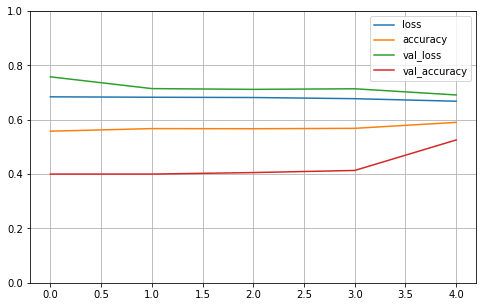

Compute valiation accuracy
2023-01-03 13:23:45.138999
Range of scores: 0.35695043 to 0.6312708
Predicted zeros and ones 191 709
Accuracy: 52.56% Precision: 45.28% Recall: 89.17% F1: 60.06%
2023-01-03 13:23:45.684028
Fold 5
Training example
[211  74  38 ...   0   0   0]
Train sizes (2525, 1997) (2525, 1)
Valid sizes (469, 1997) (469, 1)
Train set ones/size 1264 / 2525
Valid set ones/size 284 / 469
BUILD MODEL
COMPILE
FIT
2023-01-03 13:23:46.074028
Epoch 1/5
79/79 [==============================] - 1s 8ms/step - loss: 0.6932 - accuracy: 0.4986 - val_loss: 0.6940 - val_accuracy: 0.4009
Epoch 2/5
79/79 [==============================] - 0s 6ms/step - loss: 0.6882 - accuracy: 0.5414 - val_loss: 0.6776 - val_accuracy: 0.6631
Epoch 3/5
79/79 [==============================] - 0s 6ms/step - loss: 0.6741 - accuracy: 0.5786 - val_loss: 0.6609 - val_accuracy: 0.6652
Epoch 4/5
79/79 [==============================] - 0s 6ms/step - loss: 0.6408 - accuracy: 0.6360 - val_loss: 0.6427 - val_accuracy: 

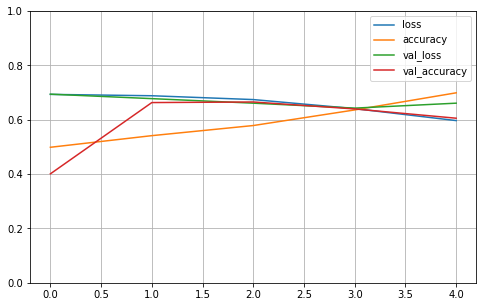

Compute valiation accuracy
2023-01-03 13:23:49.419284
Range of scores: 0.13134937 to 0.9181416
Predicted zeros and ones 200 269
Accuracy: 60.55% Precision: 68.40% Recall: 64.79% F1: 66.55%
2023-01-03 13:23:49.546267

Cross validation 5 folds 5 epochs
 accuracy mean 52.09% +/- 4.88
 precision mean 55.37% +/- 8.55
 recall mean 64.41% +/- 14.19
 F1 mean 58.11% +/- 5.74
2023-01-03 13:23:49.547094
-------------
2023-01-03 13:23:49.547151
Cell line for today: 1 = H1.hESC
Load RCI values...
Num RCI: 3327
Load genes...
2023-01-03 13:23:49.559529
Load sequence...
2023-01-03 13:23:53.526904
Num IDs: 5604
Count 1974 ones out of 5604 labels.
Num counts: 5604
2023-01-03 13:23:53.531902
splitting
Fold 1
Training example
[ 57 228 143 ...   0   0   0]
Train sizes (4381, 1997) (4381, 1)
Valid sizes (1223, 1997) (1223, 1)
Train set ones/size 1548 / 4381
Valid set ones/size 426 / 1223
BUILD MODEL
COMPILE
FIT
2023-01-03 13:23:54.263775
Epoch 1/5
137/137 [==============================] - 2s 8ms/step - los

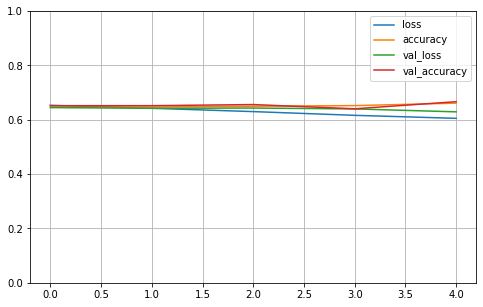

Compute valiation accuracy
2023-01-03 13:23:59.219893
Range of scores: 0.028961547 to 0.78902376
Predicted zeros and ones 1123 100
Accuracy: 66.64% Precision: 59.00% Recall: 13.85% F1: 22.43%
2023-01-03 13:23:59.465628
Fold 2
Training example
[ 57 228 143 ...   0   0   0]
Train sizes (4495, 1997) (4495, 1)
Valid sizes (1109, 1997) (1109, 1)
Train set ones/size 1586 / 4495
Valid set ones/size 388 / 1109
BUILD MODEL
COMPILE
FIT
2023-01-03 13:24:00.170308
Epoch 1/5
141/141 [==============================] - 2s 8ms/step - loss: 0.6504 - accuracy: 0.6440 - val_loss: 0.6442 - val_accuracy: 0.6501
Epoch 2/5
141/141 [==============================] - 1s 6ms/step - loss: 0.6401 - accuracy: 0.6474 - val_loss: 0.6330 - val_accuracy: 0.6519
Epoch 3/5
141/141 [==============================] - 1s 6ms/step - loss: 0.6310 - accuracy: 0.6478 - val_loss: 0.6201 - val_accuracy: 0.6601
Epoch 4/5
141/141 [==============================] - 1s 6ms/step - loss: 0.6189 - accuracy: 0.6554 - val_loss: 0.6090 - 

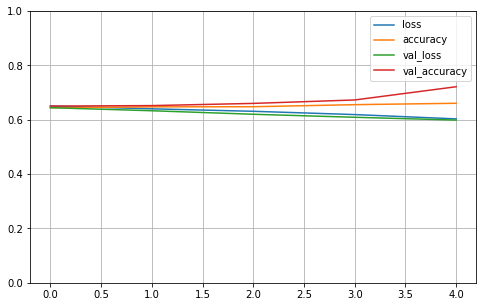

Compute valiation accuracy
2023-01-03 13:24:06.027073
Range of scores: 0.08410301 to 0.8888642
Predicted zeros and ones 920 189
Accuracy: 72.14% Precision: 70.90% Recall: 34.54% F1: 46.45%
2023-01-03 13:24:06.267020
Fold 3
Training example
[ 57 228 143 ...   0   0   0]
Train sizes (4623, 1997) (4623, 1)
Valid sizes (981, 1997) (981, 1)
Train set ones/size 1661 / 4623
Valid set ones/size 313 / 981
BUILD MODEL
COMPILE
FIT
2023-01-03 13:24:06.975627
Epoch 1/5
145/145 [==============================] - 2s 8ms/step - loss: 0.6553 - accuracy: 0.6403 - val_loss: 0.6263 - val_accuracy: 0.6809
Epoch 2/5
145/145 [==============================] - 1s 6ms/step - loss: 0.6444 - accuracy: 0.6411 - val_loss: 0.6170 - val_accuracy: 0.6830
Epoch 3/5
145/145 [==============================] - 1s 5ms/step - loss: 0.6291 - accuracy: 0.6444 - val_loss: 0.6075 - val_accuracy: 0.6922
Epoch 4/5
145/145 [==============================] - 1s 6ms/step - loss: 0.6098 - accuracy: 0.6530 - val_loss: 0.6084 - val_ac

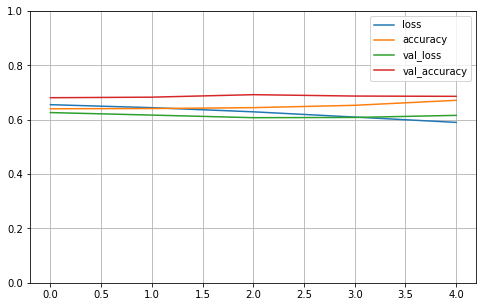

Compute valiation accuracy
2023-01-03 13:24:12.832332
Range of scores: 0.031416994 to 0.8707477
Predicted zeros and ones 888 93
Accuracy: 68.60% Precision: 52.69% Recall: 15.65% F1: 24.14%
2023-01-03 13:24:12.990714
Fold 4
Training example
[ 57 228 143 ...   0   0   0]
Train sizes (4406, 1997) (4406, 1)
Valid sizes (1198, 1997) (1198, 1)
Train set ones/size 1567 / 4406
Valid set ones/size 407 / 1198
BUILD MODEL
COMPILE
FIT
2023-01-03 13:24:13.708835
Epoch 1/5
138/138 [==============================] - 2s 8ms/step - loss: 0.6553 - accuracy: 0.6425 - val_loss: 0.6404 - val_accuracy: 0.6603
Epoch 2/5
138/138 [==============================] - 1s 6ms/step - loss: 0.6414 - accuracy: 0.6443 - val_loss: 0.6374 - val_accuracy: 0.6603
Epoch 3/5
138/138 [==============================] - 1s 6ms/step - loss: 0.6228 - accuracy: 0.6586 - val_loss: 0.6447 - val_accuracy: 0.5952
Epoch 4/5
138/138 [==============================] - 1s 6ms/step - loss: 0.6033 - accuracy: 0.6739 - val_loss: 0.6546 - val

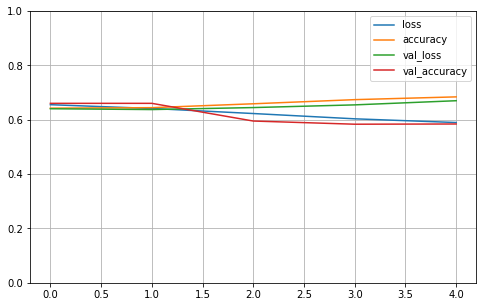

Compute valiation accuracy
2023-01-03 13:24:19.144383
Range of scores: 0.03373287 to 0.8748806
Predicted zeros and ones 923 275
Accuracy: 58.43% Precision: 33.45% Recall: 22.60% F1: 26.98%
2023-01-03 13:24:19.413075
Fold 5
Training example
[ 14  53 211 ...   0   0   0]
Train sizes (4511, 1997) (4511, 1)
Valid sizes (1093, 1997) (1093, 1)
Train set ones/size 1534 / 4511
Valid set ones/size 440 / 1093
BUILD MODEL
COMPILE
FIT
2023-01-03 13:24:20.674994
Epoch 1/5
141/141 [==============================] - 2s 8ms/step - loss: 0.6458 - accuracy: 0.6599 - val_loss: 0.6912 - val_accuracy: 0.5974
Epoch 2/5
141/141 [==============================] - 1s 6ms/step - loss: 0.6357 - accuracy: 0.6599 - val_loss: 0.6717 - val_accuracy: 0.5974
Epoch 3/5
141/141 [==============================] - 1s 6ms/step - loss: 0.6233 - accuracy: 0.6626 - val_loss: 0.6507 - val_accuracy: 0.6075
Epoch 4/5
141/141 [==============================] - 1s 6ms/step - loss: 0.6073 - accuracy: 0.6757 - val_loss: 0.6334 - val

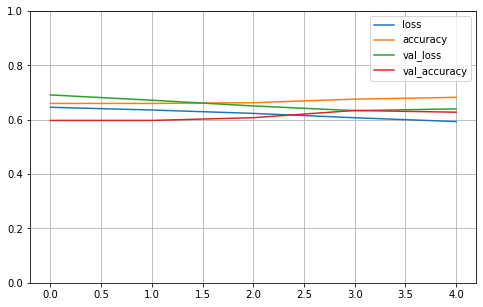

Compute valiation accuracy
2023-01-03 13:24:26.175521
Range of scores: 0.07389128 to 0.7820215
Predicted zeros and ones 972 121
Accuracy: 62.76% Precision: 63.64% Recall: 17.50% F1: 27.45%
2023-01-03 13:24:26.334775

Cross validation 5 folds 5 epochs
 accuracy mean 65.71% +/- 4.74
 precision mean 55.94% +/- 12.72
 recall mean 20.83% +/- 7.45
 F1 mean 29.49% +/- 8.68
2023-01-03 13:24:26.335826
-------------
2023-01-03 13:24:26.335890
Cell line for today: 2 = HeLa.S3
Load RCI values...
Num RCI: 919
Load genes...
2023-01-03 13:24:26.347124
Load sequence...
2023-01-03 13:24:27.795631
Num IDs: 1973
Count 505 ones out of 1973 labels.
Num counts: 1973
2023-01-03 13:24:27.796175
splitting
Fold 1
Training example
[117 210  72 ...   0   0   0]
Train sizes (1685, 1997) (1685, 1)
Valid sizes (288, 1997) (288, 1)
Train set ones/size 396 / 1685
Valid set ones/size 109 / 288
BUILD MODEL
COMPILE
FIT
2023-01-03 13:24:28.136032
Epoch 1/5
53/53 [==============================] - 1s 10ms/step - loss: 0.58

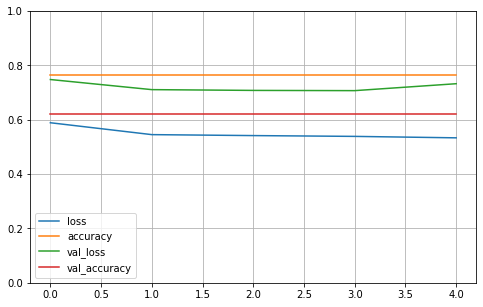

Compute valiation accuracy
2023-01-03 13:24:31.003415
Range of scores: 0.11535239 to 0.24241774
Predicted zeros and ones 288 0
Accuracy: 62.15% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:24:31.104101
Fold 2


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[ 14  53 211 ...   0   0   0]
Train sizes (1504, 1997) (1504, 1)
Valid sizes (469, 1997) (469, 1)
Train set ones/size 354 / 1504
Valid set ones/size 151 / 469
BUILD MODEL
COMPILE
FIT
2023-01-03 13:24:31.385032
Epoch 1/5
47/47 [==============================] - 1s 9ms/step - loss: 0.6053 - accuracy: 0.7580 - val_loss: 0.6523 - val_accuracy: 0.6780
Epoch 2/5
47/47 [==============================] - 0s 6ms/step - loss: 0.5453 - accuracy: 0.7646 - val_loss: 0.6437 - val_accuracy: 0.6780
Epoch 3/5
47/47 [==============================] - 0s 7ms/step - loss: 0.5414 - accuracy: 0.7646 - val_loss: 0.6510 - val_accuracy: 0.6780
Epoch 4/5
47/47 [==============================] - 0s 7ms/step - loss: 0.5395 - accuracy: 0.7646 - val_loss: 0.6545 - val_accuracy: 0.6780
Epoch 5/5
47/47 [==============================] - 0s 6ms/step - loss: 0.5366 - accuracy: 0.7646 - val_loss: 0.6438 - val_accuracy: 0.6780


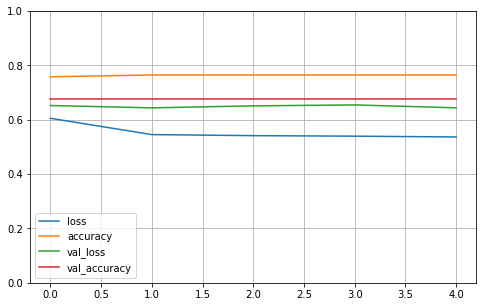

Compute valiation accuracy
2023-01-03 13:24:33.675047
Range of scores: 0.18872645 to 0.28233153
Predicted zeros and ones 469 0
Accuracy: 67.80% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:24:33.835405
Fold 3
Training example
[ 14  53 211 ...   0   0   0]
Train sizes (1417, 1997) (1417, 1)
Valid sizes (556, 1997) (556, 1)
Train set ones/size 399 / 1417
Valid set ones/size 106 / 556
BUILD MODEL
COMPILE
FIT
2023-01-03 13:24:34.105924
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


45/45 [==============================] - 1s 10ms/step - loss: 0.6273 - accuracy: 0.7184 - val_loss: 0.5031 - val_accuracy: 0.8094
Epoch 2/5
45/45 [==============================] - 0s 7ms/step - loss: 0.5930 - accuracy: 0.7184 - val_loss: 0.5115 - val_accuracy: 0.8094
Epoch 3/5
45/45 [==============================] - 0s 7ms/step - loss: 0.5897 - accuracy: 0.7184 - val_loss: 0.5034 - val_accuracy: 0.8094
Epoch 4/5
45/45 [==============================] - 0s 6ms/step - loss: 0.5855 - accuracy: 0.7184 - val_loss: 0.5002 - val_accuracy: 0.8094
Epoch 5/5
45/45 [==============================] - 0s 6ms/step - loss: 0.5797 - accuracy: 0.7184 - val_loss: 0.5071 - val_accuracy: 0.8094


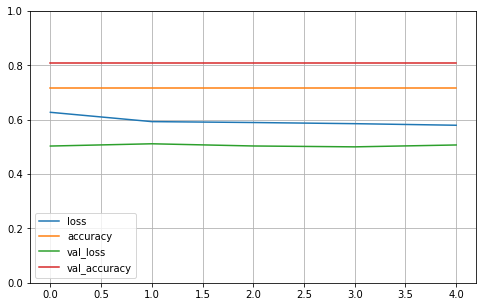

Compute valiation accuracy
2023-01-03 13:24:36.504760
Range of scores: 0.20802945 to 0.35233498
Predicted zeros and ones 556 0
Accuracy: 80.94% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:24:36.638122
Fold 4


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[ 14  53 211 ...   0   0   0]
Train sizes (1697, 1997) (1697, 1)
Valid sizes (276, 1997) (276, 1)
Train set ones/size 447 / 1697
Valid set ones/size 58 / 276
BUILD MODEL
COMPILE
FIT
2023-01-03 13:24:36.922576
Epoch 1/5
54/54 [==============================] - 1s 10ms/step - loss: 0.6178 - accuracy: 0.7319 - val_loss: 0.5181 - val_accuracy: 0.7899
Epoch 2/5
54/54 [==============================] - 0s 6ms/step - loss: 0.5735 - accuracy: 0.7366 - val_loss: 0.5251 - val_accuracy: 0.7899
Epoch 3/5
54/54 [==============================] - 0s 7ms/step - loss: 0.5722 - accuracy: 0.7366 - val_loss: 0.5177 - val_accuracy: 0.7899
Epoch 4/5
54/54 [==============================] - 0s 7ms/step - loss: 0.5673 - accuracy: 0.7366 - val_loss: 0.5187 - val_accuracy: 0.7899
Epoch 5/5
54/54 [==============================] - 0s 6ms/step - loss: 0.5619 - accuracy: 0.7366 - val_loss: 0.5227 - val_accuracy: 0.7899


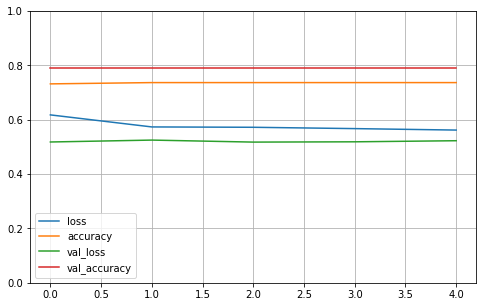

Compute valiation accuracy
2023-01-03 13:24:39.633377
Range of scores: 0.15978193 to 0.31064475
Predicted zeros and ones 276 0
Accuracy: 78.99% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:24:39.743966
Fold 5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[ 14  53 211 ...   0   0   0]
Train sizes (1589, 1997) (1589, 1)
Valid sizes (384, 1997) (384, 1)
Train set ones/size 424 / 1589
Valid set ones/size 81 / 384
BUILD MODEL
COMPILE
FIT
2023-01-03 13:24:40.038333
Epoch 1/5
50/50 [==============================] - 1s 8ms/step - loss: 0.6266 - accuracy: 0.7199 - val_loss: 0.5214 - val_accuracy: 0.7891
Epoch 2/5
50/50 [==============================] - 0s 6ms/step - loss: 0.5781 - accuracy: 0.7332 - val_loss: 0.5246 - val_accuracy: 0.7891
Epoch 3/5
50/50 [==============================] - 0s 6ms/step - loss: 0.5738 - accuracy: 0.7332 - val_loss: 0.5199 - val_accuracy: 0.7891
Epoch 4/5
50/50 [==============================] - 0s 6ms/step - loss: 0.5695 - accuracy: 0.7332 - val_loss: 0.5147 - val_accuracy: 0.7891
Epoch 5/5
50/50 [==============================] - 0s 6ms/step - loss: 0.5608 - accuracy: 0.7332 - val_loss: 0.5201 - val_accuracy: 0.7891


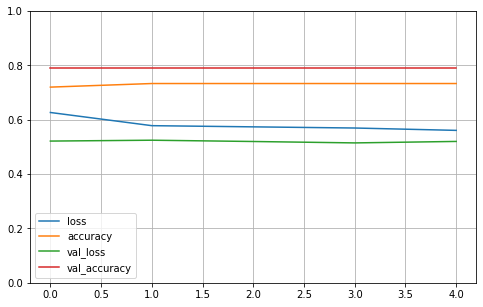

Compute valiation accuracy
2023-01-03 13:24:43.302411
Range of scores: 0.19406527 to 0.32054716
Predicted zeros and ones 384 0
Accuracy: 78.91% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:24:43.448247

Cross validation 5 folds 5 epochs
 accuracy mean 73.76% +/- 7.42
 precision mean 0.00% +/- 0.00
 recall mean 0.00% +/- 0.00
 F1 mean 0.00% +/- 0.00
2023-01-03 13:24:43.451906
-------------
2023-01-03 13:24:43.451969
Cell line for today: 3 = HepG2
Load RCI values...
Num RCI: 1362
Load genes...
2023-01-03 13:24:43.461679
Load sequence...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-01-03 13:24:45.544176
Num IDs: 2921
Count 879 ones out of 2921 labels.
Num counts: 2921
2023-01-03 13:24:45.546474
splitting
Fold 1
Training example
[211  74  38 ...   0   0   0]
Train sizes (2441, 1997) (2441, 1)
Valid sizes (480, 1997) (480, 1)
Train set ones/size 789 / 2441
Valid set ones/size 90 / 480
BUILD MODEL
COMPILE
FIT
2023-01-03 13:24:45.953413
Epoch 1/5
77/77 [==============================] - 1s 8ms/step - loss: 0.6396 - accuracy: 0.6706 - val_loss: 0.5151 - val_accuracy: 0.8125
Epoch 2/5
77/77 [==============================] - 0s 6ms/step - loss: 0.6265 - accuracy: 0.6768 - val_loss: 0.5353 - val_accuracy: 0.8125
Epoch 3/5
77/77 [==============================] - 0s 6ms/step - loss: 0.6208 - accuracy: 0.6768 - val_loss: 0.5329 - val_accuracy: 0.8125
Epoch 4/5
77/77 [==============================] - 0s 6ms/step - loss: 0.6123 - accuracy: 0.6768 - val_loss: 0.5101 - val_accuracy: 0.8125
Epoch 5/5
77/77 [==============================] - 0s 6ms/step - loss: 0.5997 - a

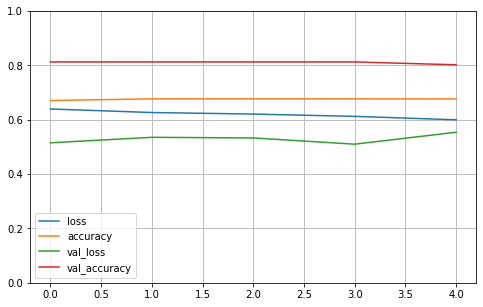

Compute valiation accuracy
2023-01-03 13:24:49.240824
Range of scores: 0.1435962 to 0.546178
Predicted zeros and ones 473 7
Accuracy: 80.21% Precision: 14.29% Recall: 1.11% F1: 2.06%
2023-01-03 13:24:49.362624
Fold 2
Training example
[211  74  38 ...   0   0   0]
Train sizes (2445, 1997) (2445, 1)
Valid sizes (476, 1997) (476, 1)
Train set ones/size 700 / 2445
Valid set ones/size 179 / 476
BUILD MODEL
COMPILE
FIT
2023-01-03 13:24:49.797453
Epoch 1/5
77/77 [==============================] - 1s 8ms/step - loss: 0.6226 - accuracy: 0.7137 - val_loss: 0.6838 - val_accuracy: 0.6239
Epoch 2/5
77/77 [==============================] - 0s 6ms/step - loss: 0.5952 - accuracy: 0.7137 - val_loss: 0.6735 - val_accuracy: 0.6239
Epoch 3/5
77/77 [==============================] - 0s 6ms/step - loss: 0.5912 - accuracy: 0.7137 - val_loss: 0.6815 - val_accuracy: 0.6239
Epoch 4/5
77/77 [==============================] - 0s 6ms/step - loss: 0.5837 - accuracy: 0.7137 - val_loss: 0.6918 - val_accuracy: 0.6239


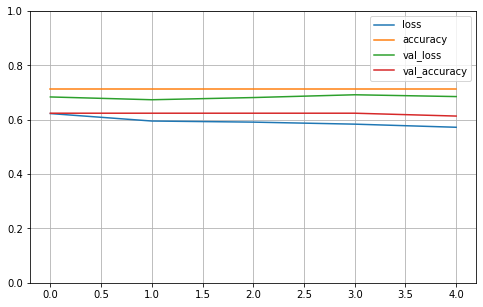

Compute valiation accuracy
2023-01-03 13:24:53.062224
Range of scores: 0.18733259 to 0.5129726
Predicted zeros and ones 471 5
Accuracy: 61.34% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:24:53.218914
Fold 3
Training example
[ 14  53 211 ...   0   0   0]
Train sizes (2093, 1997) (2093, 1)
Valid sizes (828, 1997) (828, 1)
Train set ones/size 567 / 2093
Valid set ones/size 312 / 828
BUILD MODEL
COMPILE
FIT
2023-01-03 13:24:53.625850
Epoch 1/5
66/66 [==============================] - 1s 10ms/step - loss: 0.6170 - accuracy: 0.7234 - val_loss: 0.6832 - val_accuracy: 0.6232
Epoch 2/5
66/66 [==============================] - 1s 8ms/step - loss: 0.5832 - accuracy: 0.7291 - val_loss: 0.6934 - val_accuracy: 0.6232
Epoch 3/5
66/66 [==============================] - 0s 7ms/step - loss: 0.5812 - accuracy: 0.7291 - val_loss: 0.6830 - val_accuracy: 0.6232
Epoch 4/5
66/66 [==============================] - 0s 7ms/step - loss: 0.5792 - accuracy: 0.7291 - val_loss: 0.6982 - val_accuracy: 0.623

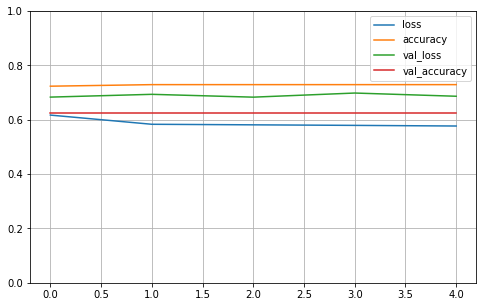

Compute valiation accuracy
2023-01-03 13:24:56.892580
Range of scores: 0.22545154 to 0.31159177
Predicted zeros and ones 828 0
Accuracy: 62.32% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:24:57.050673
Fold 4


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[211  74  38 ...   0   0   0]
Train sizes (2219, 1997) (2219, 1)
Valid sizes (702, 1997) (702, 1)
Train set ones/size 643 / 2219
Valid set ones/size 236 / 702
BUILD MODEL
COMPILE
FIT
2023-01-03 13:24:57.458331
Epoch 1/5
70/70 [==============================] - 2s 10ms/step - loss: 0.6236 - accuracy: 0.7021 - val_loss: 0.6462 - val_accuracy: 0.6638
Epoch 2/5
70/70 [==============================] - 0s 6ms/step - loss: 0.6009 - accuracy: 0.7102 - val_loss: 0.6397 - val_accuracy: 0.6638
Epoch 3/5
70/70 [==============================] - 0s 7ms/step - loss: 0.5999 - accuracy: 0.7102 - val_loss: 0.6370 - val_accuracy: 0.6638
Epoch 4/5
70/70 [==============================] - 0s 7ms/step - loss: 0.5974 - accuracy: 0.7102 - val_loss: 0.6359 - val_accuracy: 0.6638
Epoch 5/5
70/70 [==============================] - 0s 6ms/step - loss: 0.5960 - accuracy: 0.7102 - val_loss: 0.6333 - val_accuracy: 0.6638


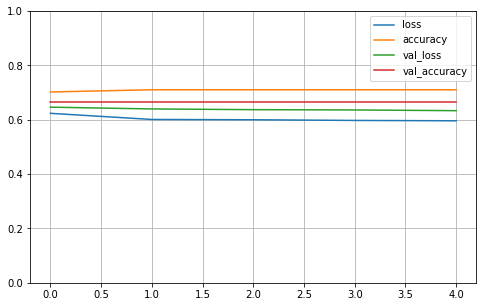

Compute valiation accuracy
2023-01-03 13:25:03.585364
Range of scores: 0.26775756 to 0.36388072
Predicted zeros and ones 702 0
Accuracy: 66.38% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:25:03.735824
Fold 5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[211  74  38 ...   0   0   0]
Train sizes (2486, 1997) (2486, 1)
Valid sizes (435, 1997) (435, 1)
Train set ones/size 817 / 2486
Valid set ones/size 62 / 435
BUILD MODEL
COMPILE
FIT
2023-01-03 13:25:04.115239
Epoch 1/5
78/78 [==============================] - 1s 8ms/step - loss: 0.6454 - accuracy: 0.6706 - val_loss: 0.5325 - val_accuracy: 0.8575
Epoch 2/5
78/78 [==============================] - 0s 6ms/step - loss: 0.6296 - accuracy: 0.6714 - val_loss: 0.4870 - val_accuracy: 0.8575
Epoch 3/5
78/78 [==============================] - 0s 6ms/step - loss: 0.6262 - accuracy: 0.6714 - val_loss: 0.5023 - val_accuracy: 0.8575
Epoch 4/5
78/78 [==============================] - 0s 6ms/step - loss: 0.6183 - accuracy: 0.6714 - val_loss: 0.5254 - val_accuracy: 0.8575
Epoch 5/5
78/78 [==============================] - 0s 6ms/step - loss: 0.6064 - accuracy: 0.6710 - val_loss: 0.5501 - val_accuracy: 0.8483


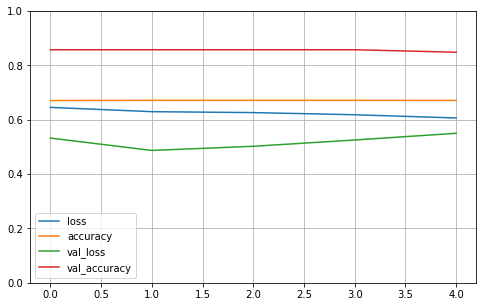

Compute valiation accuracy
2023-01-03 13:25:07.367947
Range of scores: 0.21778084 to 0.5668382
Predicted zeros and ones 427 8
Accuracy: 84.83% Precision: 25.00% Recall: 3.23% F1: 5.71%
2023-01-03 13:25:07.527374

Cross validation 5 folds 5 epochs
 accuracy mean 71.02% +/- 9.65
 precision mean 7.86% +/- 10.20
 recall mean 0.87% +/- 1.26
 F1 mean 1.56% +/- 2.23
2023-01-03 13:25:07.528205
-------------
2023-01-03 13:25:07.528260
Cell line for today: 4 = HT1080
Load RCI values...
Num RCI: 936
Load genes...
2023-01-03 13:25:07.540382
Load sequence...
2023-01-03 13:25:09.310734
Num IDs: 2500
Count 1194 ones out of 2500 labels.
Num counts: 2500
2023-01-03 13:25:09.311603
splitting
Fold 1
Training example
[117 210  72 ...   0   0   0]
Train sizes (2098, 1997) (2098, 1)
Valid sizes (402, 1997) (402, 1)
Train set ones/size 1059 / 2098
Valid set ones/size 135 / 402
BUILD MODEL
COMPILE
FIT
2023-01-03 13:25:09.689036
Epoch 1/5
66/66 [==============================] - 1s 9ms/step - loss: 0.6935 - ac

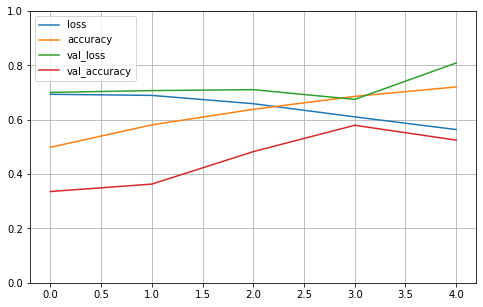

Compute valiation accuracy
2023-01-03 13:25:12.797128
Range of scores: 0.07030913 to 0.92912996
Predicted zeros and ones 128 274
Accuracy: 52.49% Precision: 39.78% Recall: 80.74% F1: 53.30%
2023-01-03 13:25:12.953639
Fold 2
Training example
[ 14  53 211 ...   0   0   0]
Train sizes (1894, 1997) (1894, 1)
Valid sizes (606, 1997) (606, 1)
Train set ones/size 759 / 1894
Valid set ones/size 435 / 606
BUILD MODEL
COMPILE
FIT
2023-01-03 13:25:13.290937
Epoch 1/5
60/60 [==============================] - 1s 9ms/step - loss: 0.6778 - accuracy: 0.5956 - val_loss: 0.8143 - val_accuracy: 0.2822
Epoch 2/5
60/60 [==============================] - 0s 7ms/step - loss: 0.6707 - accuracy: 0.5993 - val_loss: 0.8249 - val_accuracy: 0.2822
Epoch 3/5
60/60 [==============================] - 0s 7ms/step - loss: 0.6634 - accuracy: 0.5987 - val_loss: 0.8042 - val_accuracy: 0.2822
Epoch 4/5
60/60 [==============================] - 0s 6ms/step - loss: 0.6487 - accuracy: 0.6114 - val_loss: 0.8687 - val_accuracy: 

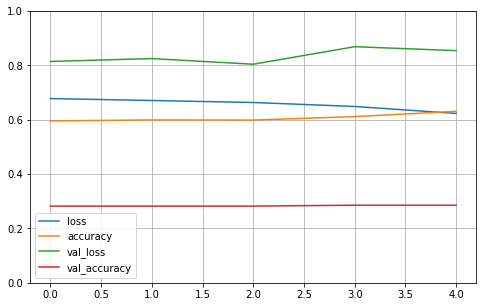

Compute valiation accuracy
2023-01-03 13:25:16.561355
Range of scores: 0.21899512 to 0.7378769
Predicted zeros and ones 550 56
Accuracy: 28.55% Precision: 51.79% Recall: 6.67% F1: 11.81%
2023-01-03 13:25:16.713040
Fold 3
Training example
[ 14  53 211 ...   0   0   0]
Train sizes (2050, 1997) (2050, 1)
Valid sizes (450, 1997) (450, 1)
Train set ones/size 1020 / 2050
Valid set ones/size 174 / 450
BUILD MODEL
COMPILE
FIT
2023-01-03 13:25:17.049800
Epoch 1/5
65/65 [==============================] - 1s 9ms/step - loss: 0.6932 - accuracy: 0.5244 - val_loss: 0.6948 - val_accuracy: 0.3911
Epoch 2/5
65/65 [==============================] - 0s 6ms/step - loss: 0.6876 - accuracy: 0.6010 - val_loss: 0.6800 - val_accuracy: 0.6378
Epoch 3/5
65/65 [==============================] - 0s 6ms/step - loss: 0.6599 - accuracy: 0.6454 - val_loss: 0.6581 - val_accuracy: 0.6644
Epoch 4/5
65/65 [==============================] - 0s 7ms/step - loss: 0.6187 - accuracy: 0.6580 - val_loss: 0.7092 - val_accuracy: 0.

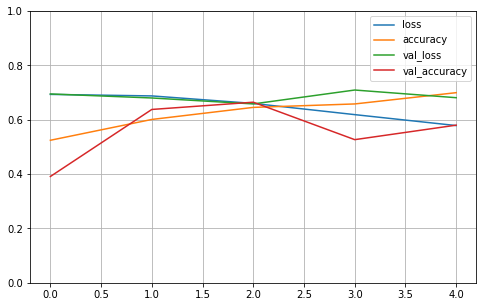

Compute valiation accuracy
2023-01-03 13:25:20.063598
Range of scores: 0.031747643 to 0.920825
Predicted zeros and ones 261 189
Accuracy: 58.00% Precision: 46.03% Recall: 50.00% F1: 47.93%
2023-01-03 13:25:20.221578
Fold 4
Training example
[ 14  53 211 ...   0   0   0]
Train sizes (1959, 1997) (1959, 1)
Valid sizes (541, 1997) (541, 1)
Train set ones/size 992 / 1959
Valid set ones/size 202 / 541
BUILD MODEL
COMPILE
FIT
2023-01-03 13:25:20.591940
Epoch 1/5
62/62 [==============================] - 1s 9ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6954 - val_accuracy: 0.3826
Epoch 2/5
62/62 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.5314 - val_loss: 0.6833 - val_accuracy: 0.6322
Epoch 3/5
62/62 [==============================] - 0s 6ms/step - loss: 0.6760 - accuracy: 0.5926 - val_loss: 0.6674 - val_accuracy: 0.6340
Epoch 4/5
62/62 [==============================] - 0s 6ms/step - loss: 0.6367 - accuracy: 0.6559 - val_loss: 0.7359 - val_accuracy: 0

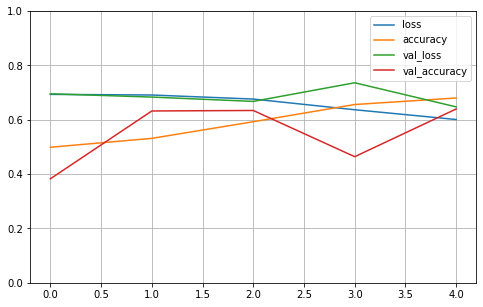

Compute valiation accuracy
2023-01-03 13:25:23.476441
Range of scores: 0.11456723 to 0.832808
Predicted zeros and ones 382 159
Accuracy: 63.96% Precision: 52.20% Recall: 41.09% F1: 45.98%
2023-01-03 13:25:23.608578
Fold 5
Training example
[ 14  53 211 ...   0   0   0]
Train sizes (1999, 1997) (1999, 1)
Valid sizes (501, 1997) (501, 1)
Train set ones/size 946 / 1999
Valid set ones/size 248 / 501
BUILD MODEL
COMPILE
FIT
2023-01-03 13:25:23.964438
Epoch 1/5
63/63 [==============================] - 1s 8ms/step - loss: 0.6924 - accuracy: 0.5188 - val_loss: 0.6938 - val_accuracy: 0.5050
Epoch 2/5
63/63 [==============================] - 0s 6ms/step - loss: 0.6901 - accuracy: 0.5268 - val_loss: 0.6899 - val_accuracy: 0.5150
Epoch 3/5
63/63 [==============================] - 0s 6ms/step - loss: 0.6786 - accuracy: 0.5738 - val_loss: 0.6756 - val_accuracy: 0.5629
Epoch 4/5
63/63 [==============================] - 0s 7ms/step - loss: 0.6440 - accuracy: 0.6443 - val_loss: 0.6472 - val_accuracy: 0.

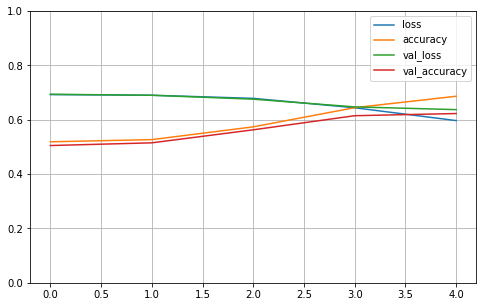

Compute valiation accuracy
2023-01-03 13:25:26.853901
Range of scores: 0.074725635 to 0.91891825
Predicted zeros and ones 356 145
Accuracy: 62.28% Precision: 70.34% Recall: 41.13% F1: 51.91%
2023-01-03 13:25:27.009234

Cross validation 5 folds 5 epochs
 accuracy mean 53.05% +/- 12.88
 precision mean 52.03% +/- 10.21
 recall mean 43.93% +/- 23.65
 F1 mean 42.19% +/- 15.41
2023-01-03 13:25:27.009915
-------------
2023-01-03 13:25:27.009970
Cell line for today: 5 = HUVEC
Load RCI values...
Num RCI: 1488
Load genes...
2023-01-03 13:25:27.022546
Load sequence...
2023-01-03 13:25:29.379284
Num IDs: 3348
Count 989 ones out of 3348 labels.
Num counts: 3348
2023-01-03 13:25:29.382322
splitting
Fold 1
Training example
[211  74  38 ...   0   0   0]
Train sizes (2693, 1997) (2693, 1)
Valid sizes (655, 1997) (655, 1)
Train set ones/size 777 / 2693
Valid set ones/size 212 / 655
BUILD MODEL
COMPILE
FIT
2023-01-03 13:25:29.850616
Epoch 1/5
85/85 [==============================] - 2s 12ms/step - loss: 

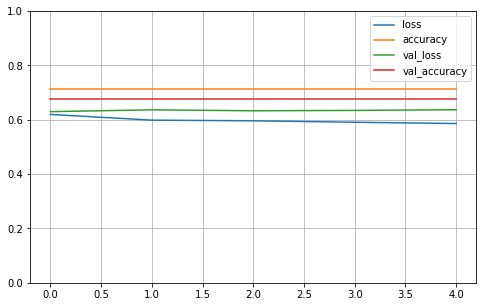

Compute valiation accuracy
2023-01-03 13:25:33.827550
Range of scores: 0.1914735 to 0.43439457
Predicted zeros and ones 655 0
Accuracy: 67.63% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:25:33.986045
Fold 2


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[ 57 228 143 ...   0   0   0]
Train sizes (2628, 1997) (2628, 1)
Valid sizes (720, 1997) (720, 1)
Train set ones/size 762 / 2628
Valid set ones/size 227 / 720
BUILD MODEL
COMPILE
FIT
2023-01-03 13:25:34.423325
Epoch 1/5
83/83 [==============================] - 1s 8ms/step - loss: 0.6226 - accuracy: 0.7055 - val_loss: 0.6244 - val_accuracy: 0.6847
Epoch 2/5
83/83 [==============================] - 1s 6ms/step - loss: 0.6014 - accuracy: 0.7100 - val_loss: 0.6243 - val_accuracy: 0.6847
Epoch 3/5
83/83 [==============================] - 1s 6ms/step - loss: 0.5974 - accuracy: 0.7100 - val_loss: 0.6256 - val_accuracy: 0.6847
Epoch 4/5
83/83 [==============================] - 1s 6ms/step - loss: 0.5943 - accuracy: 0.7100 - val_loss: 0.6202 - val_accuracy: 0.6847
Epoch 5/5
83/83 [==============================] - 1s 6ms/step - loss: 0.5888 - accuracy: 0.7100 - val_loss: 0.6189 - val_accuracy: 0.6847


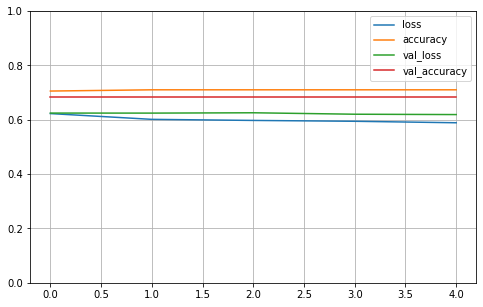

Compute valiation accuracy
2023-01-03 13:25:37.933082
Range of scores: 0.22127435 to 0.45474243
Predicted zeros and ones 720 0
Accuracy: 68.47% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:25:38.090087
Fold 3


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[211  74  38 ...   0   0   0]
Train sizes (2640, 1997) (2640, 1)
Valid sizes (708, 1997) (708, 1)
Train set ones/size 816 / 2640
Valid set ones/size 173 / 708
BUILD MODEL
COMPILE
FIT
2023-01-03 13:25:38.520833
Epoch 1/5
83/83 [==============================] - 1s 9ms/step - loss: 0.6327 - accuracy: 0.6909 - val_loss: 0.5690 - val_accuracy: 0.7556
Epoch 2/5
83/83 [==============================] - 1s 6ms/step - loss: 0.6182 - accuracy: 0.6909 - val_loss: 0.5616 - val_accuracy: 0.7556
Epoch 3/5
83/83 [==============================] - 1s 7ms/step - loss: 0.6144 - accuracy: 0.6909 - val_loss: 0.5645 - val_accuracy: 0.7556
Epoch 4/5
83/83 [==============================] - 1s 6ms/step - loss: 0.6121 - accuracy: 0.6909 - val_loss: 0.5560 - val_accuracy: 0.7556
Epoch 5/5
83/83 [==============================] - 1s 6ms/step - loss: 0.6043 - accuracy: 0.6909 - val_loss: 0.5612 - val_accuracy: 0.7556


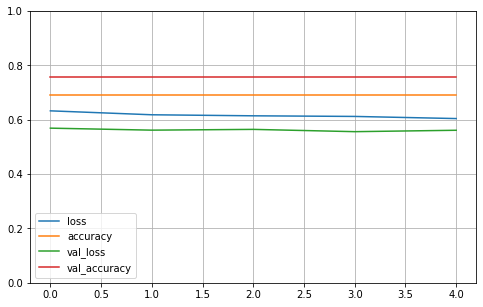

Compute valiation accuracy
2023-01-03 13:25:42.241233
Range of scores: 0.2550695 to 0.48399532
Predicted zeros and ones 708 0
Accuracy: 75.56% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:25:42.399327
Fold 4


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[211  74  38 ...   0   0   0]
Train sizes (2687, 1997) (2687, 1)
Valid sizes (661, 1997) (661, 1)
Train set ones/size 801 / 2687
Valid set ones/size 188 / 661
BUILD MODEL
COMPILE
FIT
2023-01-03 13:25:42.842565
Epoch 1/5
84/84 [==============================] - 1s 8ms/step - loss: 0.6212 - accuracy: 0.6982 - val_loss: 0.5965 - val_accuracy: 0.7156
Epoch 2/5
84/84 [==============================] - 1s 6ms/step - loss: 0.6064 - accuracy: 0.7019 - val_loss: 0.5961 - val_accuracy: 0.7156
Epoch 3/5
84/84 [==============================] - 1s 6ms/step - loss: 0.6028 - accuracy: 0.7019 - val_loss: 0.5977 - val_accuracy: 0.7156
Epoch 4/5
84/84 [==============================] - 1s 6ms/step - loss: 0.5960 - accuracy: 0.7019 - val_loss: 0.5968 - val_accuracy: 0.7156
Epoch 5/5
84/84 [==============================] - 1s 6ms/step - loss: 0.5839 - accuracy: 0.7019 - val_loss: 0.5966 - val_accuracy: 0.7171


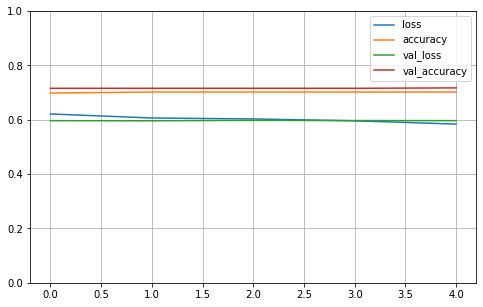

Compute valiation accuracy
2023-01-03 13:25:48.664585
Range of scores: 0.19606344 to 0.5048462
Predicted zeros and ones 660 1
Accuracy: 71.71% Precision: 100.00% Recall: 0.53% F1: 1.06%
2023-01-03 13:25:48.816867
Fold 5
Training example
[211  74  38 ...   0   0   0]
Train sizes (2744, 1997) (2744, 1)
Valid sizes (604, 1997) (604, 1)
Train set ones/size 800 / 2744
Valid set ones/size 189 / 604
BUILD MODEL
COMPILE
FIT
2023-01-03 13:25:49.258725
Epoch 1/5
86/86 [==============================] - 1s 9ms/step - loss: 0.6199 - accuracy: 0.7085 - val_loss: 0.6231 - val_accuracy: 0.6871
Epoch 2/5
86/86 [==============================] - 1s 7ms/step - loss: 0.6013 - accuracy: 0.7085 - val_loss: 0.6213 - val_accuracy: 0.6871
Epoch 3/5
86/86 [==============================] - 1s 6ms/step - loss: 0.5972 - accuracy: 0.7085 - val_loss: 0.6233 - val_accuracy: 0.6871
Epoch 4/5
86/86 [==============================] - 1s 6ms/step - loss: 0.5924 - accuracy: 0.7085 - val_loss: 0.6294 - val_accuracy: 0.68

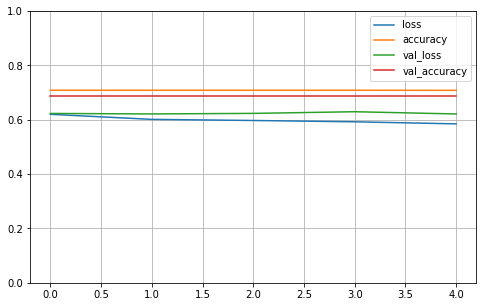

Compute valiation accuracy
2023-01-03 13:25:55.090908
Range of scores: 0.19330472 to 0.47638035
Predicted zeros and ones 604 0
Accuracy: 68.71% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:25:55.227150

Cross validation 5 folds 5 epochs
 accuracy mean 70.42% +/- 2.92
 precision mean 20.00% +/- 40.00
 recall mean 0.11% +/- 0.21
 F1 mean 0.21% +/- 0.42
2023-01-03 13:25:55.228077
-------------
2023-01-03 13:25:55.228133
Cell line for today: 6 = MCF.7
Load RCI values...
Num RCI: 2156
Load genes...
2023-01-03 13:25:55.241372
Load sequence...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-01-03 13:25:58.033315
Num IDs: 3948
Count 1229 ones out of 3948 labels.
Num counts: 3948
2023-01-03 13:25:58.099776
splitting
Fold 1
Training example
[ 57 228 143 ...   0   0   0]
Train sizes (3139, 1997) (3139, 1)
Valid sizes (809, 1997) (809, 1)
Train set ones/size 1046 / 3139
Valid set ones/size 183 / 809
BUILD MODEL
COMPILE
FIT
2023-01-03 13:25:58.617605
Epoch 1/5
99/99 [==============================] - 1s 9ms/step - loss: 0.6439 - accuracy: 0.6642 - val_loss: 0.5549 - val_accuracy: 0.7738
Epoch 2/5
99/99 [==============================] - 1s 7ms/step - loss: 0.6318 - accuracy: 0.6668 - val_loss: 0.5649 - val_accuracy: 0.7738
Epoch 3/5
99/99 [==============================] - 1s 7ms/step - loss: 0.6231 - accuracy: 0.6668 - val_loss: 0.5619 - val_accuracy: 0.7738
Epoch 4/5
99/99 [==============================] - 1s 6ms/step - loss: 0.6069 - accuracy: 0.6731 - val_loss: 0.5483 - val_accuracy: 0.7676
Epoch 5/5
99/99 [==============================] - 1s 6ms/step - loss: 0.5882 

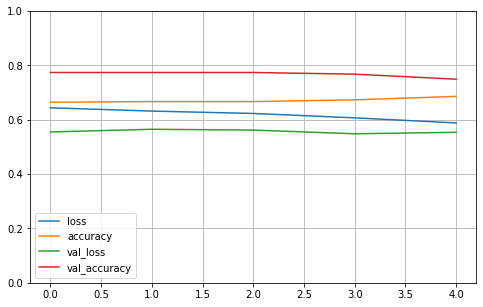

Compute valiation accuracy
2023-01-03 13:26:04.439685
Range of scores: 0.061985794 to 0.6345364
Predicted zeros and ones 753 56
Accuracy: 74.91% Precision: 32.14% Recall: 9.84% F1: 15.06%
2023-01-03 13:26:04.582745
Fold 2
Training example
[ 57 228 143 ...   0   0   0]
Train sizes (3140, 1997) (3140, 1)
Valid sizes (808, 1997) (808, 1)
Train set ones/size 1002 / 3140
Valid set ones/size 227 / 808
BUILD MODEL
COMPILE
FIT
2023-01-03 13:26:05.090445
Epoch 1/5
99/99 [==============================] - 1s 9ms/step - loss: 0.6363 - accuracy: 0.6809 - val_loss: 0.5988 - val_accuracy: 0.7191
Epoch 2/5
99/99 [==============================] - 1s 6ms/step - loss: 0.6192 - accuracy: 0.6809 - val_loss: 0.5938 - val_accuracy: 0.7191
Epoch 3/5
99/99 [==============================] - 1s 6ms/step - loss: 0.6065 - accuracy: 0.6809 - val_loss: 0.6023 - val_accuracy: 0.7191
Epoch 4/5
99/99 [==============================] - 1s 7ms/step - loss: 0.5884 - accuracy: 0.6904 - val_loss: 0.6029 - val_accuracy: 0

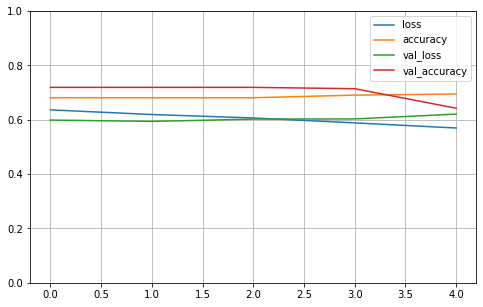

Compute valiation accuracy
2023-01-03 13:26:10.909441
Range of scores: 0.07471886 to 0.7949375
Predicted zeros and ones 680 128
Accuracy: 64.23% Precision: 25.78% Recall: 14.54% F1: 18.59%
2023-01-03 13:26:11.070267
Fold 3
Training example
[ 57 228 143 ...   0   0   0]
Train sizes (3040, 1997) (3040, 1)
Valid sizes (908, 1997) (908, 1)
Train set ones/size 910 / 3040
Valid set ones/size 319 / 908
BUILD MODEL
COMPILE
FIT
2023-01-03 13:26:11.589308
Epoch 1/5
95/95 [==============================] - 1s 9ms/step - loss: 0.6218 - accuracy: 0.7003 - val_loss: 0.6587 - val_accuracy: 0.6487
Epoch 2/5
95/95 [==============================] - 1s 6ms/step - loss: 0.6041 - accuracy: 0.7007 - val_loss: 0.6510 - val_accuracy: 0.6487
Epoch 3/5
95/95 [==============================] - 1s 7ms/step - loss: 0.5952 - accuracy: 0.7007 - val_loss: 0.6506 - val_accuracy: 0.6487
Epoch 4/5
95/95 [==============================] - 1s 7ms/step - loss: 0.5798 - accuracy: 0.7003 - val_loss: 0.6546 - val_accuracy: 0

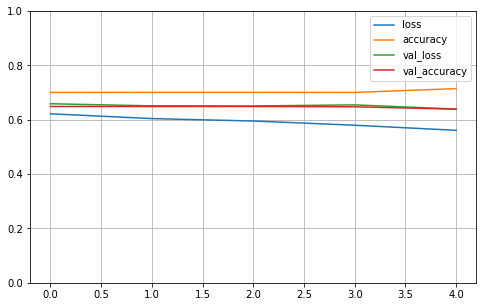

Compute valiation accuracy
2023-01-03 13:26:17.308599
Range of scores: 0.039670337 to 0.655078
Predicted zeros and ones 895 13
Accuracy: 63.88% Precision: 15.38% Recall: 0.63% F1: 1.20%
2023-01-03 13:26:17.803038
Fold 4
Training example
[ 57 228 143 ...   0   0   0]
Train sizes (3300, 1997) (3300, 1)
Valid sizes (648, 1997) (648, 1)
Train set ones/size 1038 / 3300
Valid set ones/size 191 / 648
BUILD MODEL
COMPILE
FIT
2023-01-03 13:26:18.320347
Epoch 1/5
104/104 [==============================] - 1s 8ms/step - loss: 0.6337 - accuracy: 0.6855 - val_loss: 0.6069 - val_accuracy: 0.7052
Epoch 2/5
104/104 [==============================] - 1s 6ms/step - loss: 0.6156 - accuracy: 0.6855 - val_loss: 0.6004 - val_accuracy: 0.7052
Epoch 3/5
104/104 [==============================] - 1s 6ms/step - loss: 0.6018 - accuracy: 0.6855 - val_loss: 0.5946 - val_accuracy: 0.6975
Epoch 4/5
104/104 [==============================] - 1s 6ms/step - loss: 0.5808 - accuracy: 0.6936 - val_loss: 0.5962 - val_accur

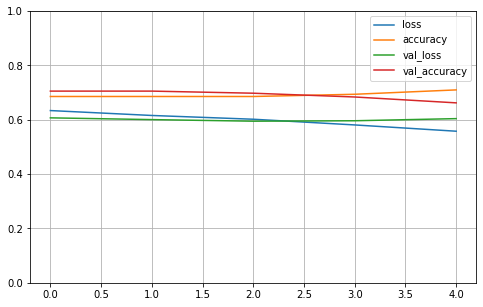

Compute valiation accuracy
2023-01-03 13:26:22.536170
Range of scores: 0.083386436 to 0.80227065
Predicted zeros and ones 576 72
Accuracy: 66.20% Precision: 30.56% Recall: 11.52% F1: 16.73%
2023-01-03 13:26:22.680203
Fold 5
Training example
[ 14  53 211 ...   0   0   0]
Train sizes (3173, 1997) (3173, 1)
Valid sizes (775, 1997) (775, 1)
Train set ones/size 920 / 3173
Valid set ones/size 309 / 775
BUILD MODEL
COMPILE
FIT
2023-01-03 13:26:23.184682
Epoch 1/5
100/100 [==============================] - 1s 8ms/step - loss: 0.6168 - accuracy: 0.7044 - val_loss: 0.6883 - val_accuracy: 0.6013
Epoch 2/5
100/100 [==============================] - 1s 6ms/step - loss: 0.5986 - accuracy: 0.7101 - val_loss: 0.6799 - val_accuracy: 0.6013
Epoch 3/5
100/100 [==============================] - 1s 6ms/step - loss: 0.5934 - accuracy: 0.7101 - val_loss: 0.6730 - val_accuracy: 0.6013
Epoch 4/5
100/100 [==============================] - 1s 6ms/step - loss: 0.5853 - accuracy: 0.7101 - val_loss: 0.6629 - val_ac

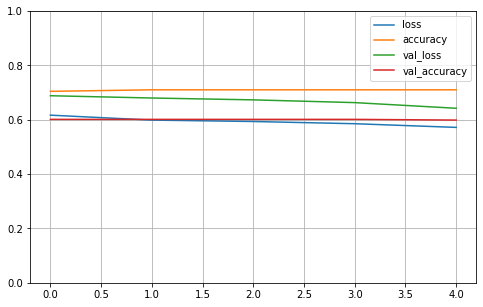

Compute valiation accuracy
2023-01-03 13:26:29.009279
Range of scores: 0.15155108 to 0.61071074
Predicted zeros and ones 769 6
Accuracy: 59.87% Precision: 33.33% Recall: 0.65% F1: 1.27%
2023-01-03 13:26:29.163689

Cross validation 5 folds 5 epochs
 accuracy mean 65.82% +/- 4.99
 precision mean 27.44% +/- 6.55
 recall mean 7.43% +/- 5.75
 F1 mean 10.57% +/- 7.70
2023-01-03 13:26:29.164600
-------------
2023-01-03 13:26:29.164659
Cell line for today: 7 = NCI.H460
Load RCI values...
Num RCI: 610
Load genes...
2023-01-03 13:26:29.180817
Load sequence...
2023-01-03 13:26:30.515799
Num IDs: 1844
Count 431 ones out of 1844 labels.
Num counts: 1844
2023-01-03 13:26:30.518980
splitting
Fold 1
Training example
[ 89  99 140 ...   0   0   0]
Train sizes (1423, 1997) (1423, 1)
Valid sizes (421, 1997) (421, 1)
Train set ones/size 379 / 1423
Valid set ones/size 52 / 421
BUILD MODEL
COMPILE
FIT
2023-01-03 13:26:30.813606
Epoch 1/5
45/45 [==============================] - 1s 11ms/step - loss: 0.6291 - 

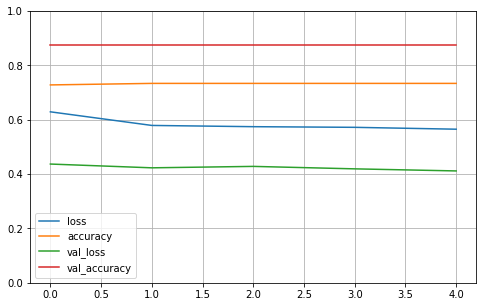

Compute valiation accuracy
2023-01-03 13:26:33.385597
Range of scores: 0.18479627 to 0.2703221
Predicted zeros and ones 421 0
Accuracy: 87.65% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:26:33.513575
Fold 2


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[117 210  72 ...   0   0   0]
Train sizes (1509, 1997) (1509, 1)
Valid sizes (335, 1997) (335, 1)
Train set ones/size 331 / 1509
Valid set ones/size 100 / 335
BUILD MODEL
COMPILE
FIT
2023-01-03 13:26:33.783430
Epoch 1/5
48/48 [==============================] - 1s 10ms/step - loss: 0.5932 - accuracy: 0.7793 - val_loss: 0.6354 - val_accuracy: 0.7015
Epoch 2/5
48/48 [==============================] - 0s 7ms/step - loss: 0.5250 - accuracy: 0.7806 - val_loss: 0.6284 - val_accuracy: 0.7015
Epoch 3/5
48/48 [==============================] - 0s 7ms/step - loss: 0.5205 - accuracy: 0.7806 - val_loss: 0.6298 - val_accuracy: 0.7015
Epoch 4/5
48/48 [==============================] - 0s 7ms/step - loss: 0.5163 - accuracy: 0.7806 - val_loss: 0.6311 - val_accuracy: 0.7015
Epoch 5/5
48/48 [==============================] - 0s 7ms/step - loss: 0.5105 - accuracy: 0.7806 - val_loss: 0.6375 - val_accuracy: 0.7015


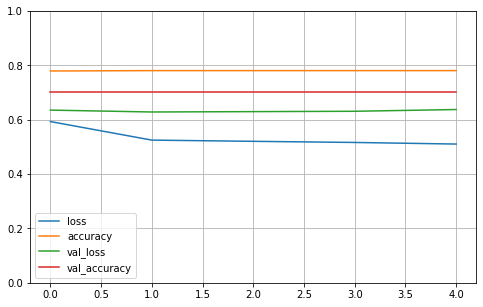

Compute valiation accuracy
2023-01-03 13:26:36.357800
Range of scores: 0.16458446 to 0.26569232
Predicted zeros and ones 335 0
Accuracy: 70.15% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:26:36.518946
Fold 3


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[117 210  72 ...   0   0   0]
Train sizes (1501, 1997) (1501, 1)
Valid sizes (343, 1997) (343, 1)
Train set ones/size 397 / 1501
Valid set ones/size 34 / 343
BUILD MODEL
COMPILE
FIT
2023-01-03 13:26:36.788780
Epoch 1/5
47/47 [==============================] - 1s 10ms/step - loss: 0.6222 - accuracy: 0.7302 - val_loss: 0.3944 - val_accuracy: 0.9009
Epoch 2/5
47/47 [==============================] - 0s 7ms/step - loss: 0.5764 - accuracy: 0.7355 - val_loss: 0.4031 - val_accuracy: 0.9009
Epoch 3/5
47/47 [==============================] - 0s 7ms/step - loss: 0.5729 - accuracy: 0.7355 - val_loss: 0.4147 - val_accuracy: 0.9009
Epoch 4/5
47/47 [==============================] - 0s 7ms/step - loss: 0.5670 - accuracy: 0.7355 - val_loss: 0.3953 - val_accuracy: 0.9009
Epoch 5/5
47/47 [==============================] - 0s 7ms/step - loss: 0.5589 - accuracy: 0.7355 - val_loss: 0.4012 - val_accuracy: 0.9009


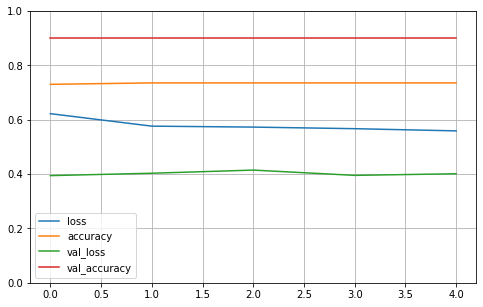

Compute valiation accuracy
2023-01-03 13:26:40.043639
Range of scores: 0.22853865 to 0.2810972
Predicted zeros and ones 343 0
Accuracy: 90.09% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:26:40.203020
Fold 4


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[117 210  72 ...   0   0   0]
Train sizes (1494, 1997) (1494, 1)
Valid sizes (350, 1997) (350, 1)
Train set ones/size 271 / 1494
Valid set ones/size 160 / 350
BUILD MODEL
COMPILE
FIT
2023-01-03 13:26:40.474303
Epoch 1/5
47/47 [==============================] - 1s 10ms/step - loss: 0.5834 - accuracy: 0.8039 - val_loss: 0.8504 - val_accuracy: 0.5429
Epoch 2/5
47/47 [==============================] - 0s 7ms/step - loss: 0.4725 - accuracy: 0.8186 - val_loss: 0.8824 - val_accuracy: 0.5429
Epoch 3/5
47/47 [==============================] - 0s 8ms/step - loss: 0.4690 - accuracy: 0.8186 - val_loss: 0.8861 - val_accuracy: 0.5429
Epoch 4/5
47/47 [==============================] - 0s 7ms/step - loss: 0.4655 - accuracy: 0.8186 - val_loss: 0.9121 - val_accuracy: 0.5429
Epoch 5/5
47/47 [==============================] - 0s 8ms/step - loss: 0.4615 - accuracy: 0.8186 - val_loss: 0.9175 - val_accuracy: 0.5429


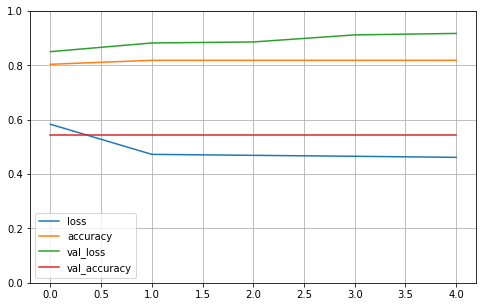

Compute valiation accuracy
2023-01-03 13:26:43.731112
Range of scores: 0.14977415 to 0.22905184
Predicted zeros and ones 350 0
Accuracy: 54.29% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:26:43.883684
Fold 5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[117 210  72 ...   0   0   0]
Train sizes (1449, 1997) (1449, 1)
Valid sizes (395, 1997) (395, 1)
Train set ones/size 346 / 1449
Valid set ones/size 85 / 395
BUILD MODEL
COMPILE
FIT
2023-01-03 13:26:44.160185
Epoch 1/5
46/46 [==============================] - 1s 11ms/step - loss: 0.6078 - accuracy: 0.7578 - val_loss: 0.5202 - val_accuracy: 0.7848
Epoch 2/5
46/46 [==============================] - 0s 7ms/step - loss: 0.5492 - accuracy: 0.7612 - val_loss: 0.5208 - val_accuracy: 0.7848
Epoch 3/5
46/46 [==============================] - 0s 7ms/step - loss: 0.5441 - accuracy: 0.7612 - val_loss: 0.5218 - val_accuracy: 0.7848
Epoch 4/5
46/46 [==============================] - 0s 8ms/step - loss: 0.5396 - accuracy: 0.7612 - val_loss: 0.5239 - val_accuracy: 0.7848
Epoch 5/5
46/46 [==============================] - 0s 7ms/step - loss: 0.5341 - accuracy: 0.7612 - val_loss: 0.5241 - val_accuracy: 0.7848


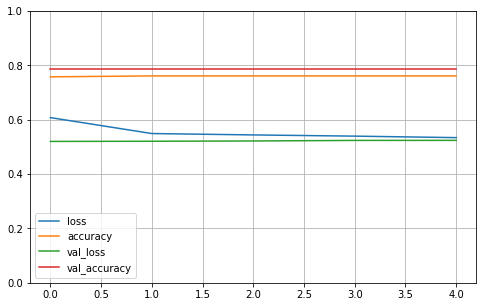

Compute valiation accuracy
2023-01-03 13:26:47.390399
Range of scores: 0.17470157 to 0.24864022
Predicted zeros and ones 395 0
Accuracy: 78.48% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:26:47.506566

Cross validation 5 folds 5 epochs
 accuracy mean 76.13% +/- 13.01
 precision mean 0.00% +/- 0.00
 recall mean 0.00% +/- 0.00
 F1 mean 0.00% +/- 0.00
2023-01-03 13:26:47.507571
-------------
2023-01-03 13:26:47.507629
Cell line for today: 8 = NHEK
Load RCI values...
Num RCI: 1080
Load genes...
2023-01-03 13:26:47.520782
Load sequence...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-01-03 13:26:49.575317
Num IDs: 2894
Count 1104 ones out of 2894 labels.
Num counts: 2894
2023-01-03 13:26:49.576056
splitting
Fold 1
Training example
[211  74  38 ...   0   0   0]
Train sizes (2208, 1997) (2208, 1)
Valid sizes (686, 1997) (686, 1)
Train set ones/size 843 / 2208
Valid set ones/size 261 / 686
BUILD MODEL
COMPILE
FIT
2023-01-03 13:26:50.007068
Epoch 1/5
69/69 [==============================] - 1s 10ms/step - loss: 0.6726 - accuracy: 0.6146 - val_loss: 0.6634 - val_accuracy: 0.6195
Epoch 2/5
69/69 [==============================] - 0s 7ms/step - loss: 0.6598 - accuracy: 0.6182 - val_loss: 0.6598 - val_accuracy: 0.6195
Epoch 3/5
69/69 [==============================] - 0s 7ms/step - loss: 0.6474 - accuracy: 0.6205 - val_loss: 0.6556 - val_accuracy: 0.6093
Epoch 4/5
69/69 [==============================] - 0s 7ms/step - loss: 0.6298 - accuracy: 0.6553 - val_loss: 0.6514 - val_accuracy: 0.6312
Epoch 5/5
69/69 [==============================] - 0s 7ms/step - loss: 0.6139 

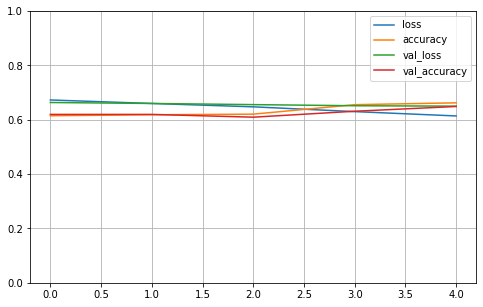

Compute valiation accuracy
2023-01-03 13:26:53.648625
Range of scores: 0.069271974 to 0.72846276
Predicted zeros and ones 596 90
Accuracy: 64.87% Precision: 61.11% Recall: 21.07% F1: 31.34%
2023-01-03 13:26:53.799411
Fold 2
Training example
[211  74  38 ...   0   0   0]
Train sizes (2475, 1997) (2475, 1)
Valid sizes (419, 1997) (419, 1)
Train set ones/size 965 / 2475
Valid set ones/size 139 / 419
BUILD MODEL
COMPILE
FIT
2023-01-03 13:26:54.185290
Epoch 1/5
78/78 [==============================] - 1s 9ms/step - loss: 0.6719 - accuracy: 0.6057 - val_loss: 0.6366 - val_accuracy: 0.6683
Epoch 2/5
78/78 [==============================] - 1s 7ms/step - loss: 0.6580 - accuracy: 0.6101 - val_loss: 0.6368 - val_accuracy: 0.6683
Epoch 3/5
78/78 [==============================] - 1s 7ms/step - loss: 0.6326 - accuracy: 0.6335 - val_loss: 0.6714 - val_accuracy: 0.6635
Epoch 4/5
78/78 [==============================] - 0s 6ms/step - loss: 0.6071 - accuracy: 0.6731 - val_loss: 0.6824 - val_accuracy: 

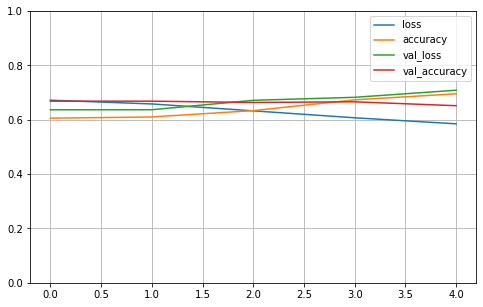

Compute valiation accuracy
2023-01-03 13:26:59.996972
Range of scores: 0.11131281 to 0.8146594
Predicted zeros and ones 298 121
Accuracy: 65.16% Precision: 47.11% Recall: 41.01% F1: 43.85%
2023-01-03 13:27:00.153229
Fold 3
Training example
[22 88 94 ...  0  0  0]
Train sizes (2128, 1997) (2128, 1)
Valid sizes (766, 1997) (766, 1)
Train set ones/size 740 / 2128
Valid set ones/size 364 / 766
BUILD MODEL
COMPILE
FIT
2023-01-03 13:27:00.535865
Epoch 1/5
67/67 [==============================] - 1s 11ms/step - loss: 0.6558 - accuracy: 0.6485 - val_loss: 0.7356 - val_accuracy: 0.5248
Epoch 2/5
67/67 [==============================] - 0s 7ms/step - loss: 0.6448 - accuracy: 0.6523 - val_loss: 0.7217 - val_accuracy: 0.5248
Epoch 3/5
67/67 [==============================] - 0s 7ms/step - loss: 0.6432 - accuracy: 0.6523 - val_loss: 0.7113 - val_accuracy: 0.5248
Epoch 4/5
67/67 [==============================] - 0s 7ms/step - loss: 0.6397 - accuracy: 0.6523 - val_loss: 0.7095 - val_accuracy: 0.5248

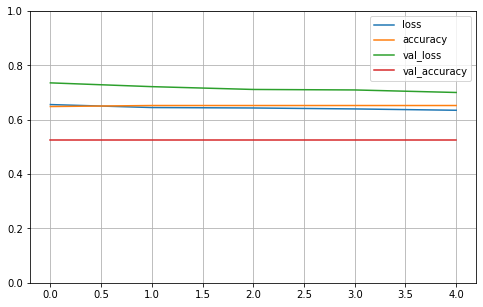

Compute valiation accuracy
2023-01-03 13:27:06.358111
Range of scores: 0.27252457 to 0.44415456
Predicted zeros and ones 766 0
Accuracy: 52.48% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:27:06.509798
Fold 4


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[211  74  38 ...   0   0   0]
Train sizes (2422, 1997) (2422, 1)
Valid sizes (472, 1997) (472, 1)
Train set ones/size 939 / 2422
Valid set ones/size 165 / 472
BUILD MODEL
COMPILE
FIT
2023-01-03 13:27:06.903953
Epoch 1/5
76/76 [==============================] - 1s 9ms/step - loss: 0.6730 - accuracy: 0.5974 - val_loss: 0.6494 - val_accuracy: 0.6504
Epoch 2/5
76/76 [==============================] - 1s 7ms/step - loss: 0.6561 - accuracy: 0.6127 - val_loss: 0.6552 - val_accuracy: 0.6398
Epoch 3/5
76/76 [==============================] - 1s 7ms/step - loss: 0.6340 - accuracy: 0.6358 - val_loss: 0.6484 - val_accuracy: 0.6186
Epoch 4/5
76/76 [==============================] - 0s 6ms/step - loss: 0.6099 - accuracy: 0.6751 - val_loss: 0.6515 - val_accuracy: 0.6186
Epoch 5/5
76/76 [==============================] - 0s 6ms/step - loss: 0.5875 - accuracy: 0.6903 - val_loss: 0.6691 - val_accuracy: 0.5445


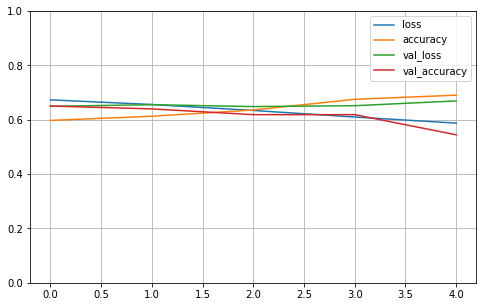

Compute valiation accuracy
2023-01-03 13:27:12.728178
Range of scores: 0.084424205 to 0.8253948
Predicted zeros and ones 336 136
Accuracy: 54.45% Precision: 31.62% Recall: 26.06% F1: 28.57%
2023-01-03 13:27:12.844967
Fold 5
Training example
[211  74  38 ...   0   0   0]
Train sizes (2343, 1997) (2343, 1)
Valid sizes (551, 1997) (551, 1)
Train set ones/size 929 / 2343
Valid set ones/size 175 / 551
BUILD MODEL
COMPILE
FIT
2023-01-03 13:27:13.223293
Epoch 1/5
74/74 [==============================] - 1s 9ms/step - loss: 0.6741 - accuracy: 0.6035 - val_loss: 0.6363 - val_accuracy: 0.6824
Epoch 2/5
74/74 [==============================] - 0s 7ms/step - loss: 0.6600 - accuracy: 0.6035 - val_loss: 0.6529 - val_accuracy: 0.6806
Epoch 3/5
74/74 [==============================] - 1s 7ms/step - loss: 0.6366 - accuracy: 0.6304 - val_loss: 0.6615 - val_accuracy: 0.6352
Epoch 4/5
74/74 [==============================] - 0s 7ms/step - loss: 0.6092 - accuracy: 0.6718 - val_loss: 0.7004 - val_accuracy: 

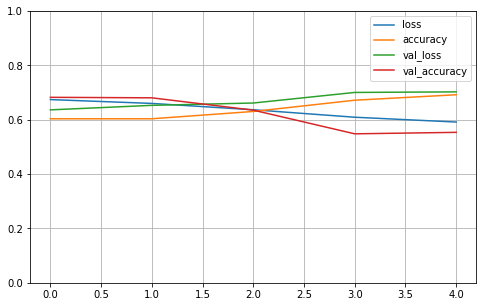

Compute valiation accuracy
2023-01-03 13:27:16.583446
Range of scores: 0.054694634 to 0.88313985
Predicted zeros and ones 418 133
Accuracy: 55.35% Precision: 23.31% Recall: 17.71% F1: 20.13%
2023-01-03 13:27:16.737267

Cross validation 5 folds 5 epochs
 accuracy mean 58.46% +/- 5.43
 precision mean 32.63% +/- 20.85
 recall mean 21.17% +/- 13.25
 F1 mean 24.78% +/- 14.54
2023-01-03 13:27:16.738092
-------------
2023-01-03 13:27:16.738144
Cell line for today: 9 = SK.MEL.5
Load RCI values...
Num RCI: 534
Load genes...
2023-01-03 13:27:16.750190
Load sequence...
2023-01-03 13:27:18.126895
Num IDs: 1886
Count 433 ones out of 1886 labels.
Num counts: 1886
2023-01-03 13:27:18.129743
splitting
Fold 1
Training example
[ 14  53 211 ...   0   0   0]
Train sizes (1528, 1997) (1528, 1)
Valid sizes (358, 1997) (358, 1)
Train set ones/size 332 / 1528
Valid set ones/size 101 / 358
BUILD MODEL
COMPILE
FIT
2023-01-03 13:27:18.411558
Epoch 1/5
48/48 [==============================] - 1s 10ms/step - loss:

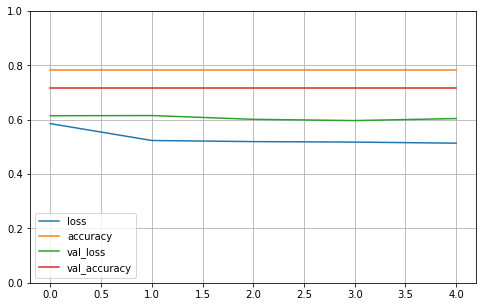

Compute valiation accuracy
2023-01-03 13:27:21.706128
Range of scores: 0.1897697 to 0.262351
Predicted zeros and ones 358 0
Accuracy: 71.79% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:27:21.823878
Fold 2
Training example

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[ 14  53 211 ...   0   0   0]
Train sizes (1439, 1997) (1439, 1)
Valid sizes (447, 1997) (447, 1)
Train set ones/size 377 / 1439
Valid set ones/size 56 / 447
BUILD MODEL
COMPILE
FIT
2023-01-03 13:27:22.121682
Epoch 1/5
45/45 [==============================] - 1s 12ms/step - loss: 0.6250 - accuracy: 0.7380 - val_loss: 0.4362 - val_accuracy: 0.8747
Epoch 2/5
45/45 [==============================] - 0s 8ms/step - loss: 0.5734 - accuracy: 0.7380 - val_loss: 0.4239 - val_accuracy: 0.8747
Epoch 3/5
45/45 [==============================] - 0s 7ms/step - loss: 0.5706 - accuracy: 0.7380 - val_loss: 0.4335 - val_accuracy: 0.8747
Epoch 4/5
45/45 [==============================] - 0s 7ms/step - loss: 0.5674 - accuracy: 0.7380 - val_loss: 0.4351 - val_accuracy: 0.8747
Epoch 5/5
45/45 [==============================] - 0s 7ms/step - loss: 0.5653 - accuracy: 0.7380 - val_loss: 0.4314 - val_accuracy: 0.8747


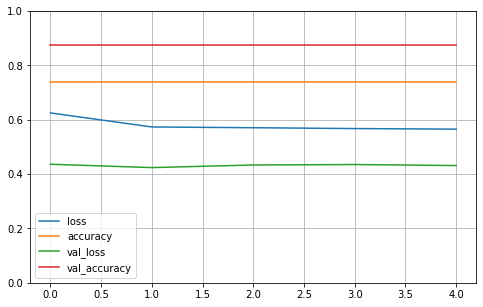

Compute valiation accuracy
2023-01-03 13:27:25.380766
Range of scores: 0.21144746 to 0.31415182
Predicted zeros and ones 447 0
Accuracy: 87.47% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:27:25.532475
Fold 3


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[ 14  53 211 ...   0   0   0]
Train sizes (1526, 1997) (1526, 1)
Valid sizes (360, 1997) (360, 1)
Train set ones/size 310 / 1526
Valid set ones/size 123 / 360
BUILD MODEL
COMPILE
FIT
2023-01-03 13:27:25.812526
Epoch 1/5
48/48 [==============================] - 2s 12ms/step - loss: 0.5918 - accuracy: 0.7936 - val_loss: 0.6885 - val_accuracy: 0.6583
Epoch 2/5
48/48 [==============================] - 0s 9ms/step - loss: 0.5029 - accuracy: 0.7969 - val_loss: 0.7013 - val_accuracy: 0.6583
Epoch 3/5
48/48 [==============================] - 0s 10ms/step - loss: 0.4998 - accuracy: 0.7969 - val_loss: 0.7292 - val_accuracy: 0.6583
Epoch 4/5
48/48 [==============================] - 0s 9ms/step - loss: 0.4975 - accuracy: 0.7969 - val_loss: 0.7115 - val_accuracy: 0.6583
Epoch 5/5
48/48 [==============================] - 0s 9ms/step - loss: 0.4927 - accuracy: 0.7969 - val_loss: 0.6840 - val_accuracy: 0.6583


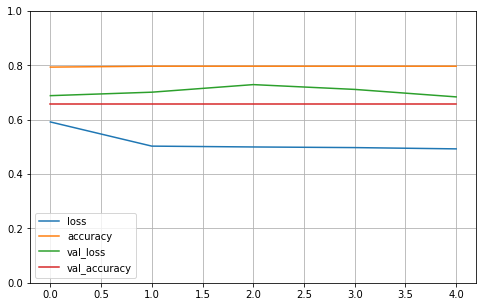

Compute valiation accuracy
2023-01-03 13:27:29.534104
Range of scores: 0.19234616 to 0.2794471
Predicted zeros and ones 360 0
Accuracy: 65.83% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:27:29.702505
Fold 4


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[117 210  72 ...   0   0   0]
Train sizes (1458, 1997) (1458, 1)
Valid sizes (428, 1997) (428, 1)
Train set ones/size 320 / 1458
Valid set ones/size 113 / 428
BUILD MODEL
COMPILE
FIT
2023-01-03 13:27:29.975868
Epoch 1/5
46/46 [==============================] - 1s 11ms/step - loss: 0.5977 - accuracy: 0.7805 - val_loss: 0.5801 - val_accuracy: 0.7360
Epoch 2/5
46/46 [==============================] - 0s 8ms/step - loss: 0.5247 - accuracy: 0.7805 - val_loss: 0.5785 - val_accuracy: 0.7360
Epoch 3/5
46/46 [==============================] - 0s 7ms/step - loss: 0.5219 - accuracy: 0.7805 - val_loss: 0.5879 - val_accuracy: 0.7360
Epoch 4/5
46/46 [==============================] - 0s 8ms/step - loss: 0.5200 - accuracy: 0.7805 - val_loss: 0.5868 - val_accuracy: 0.7360
Epoch 5/5
46/46 [==============================] - 0s 8ms/step - loss: 0.5157 - accuracy: 0.7805 - val_loss: 0.5872 - val_accuracy: 0.7360


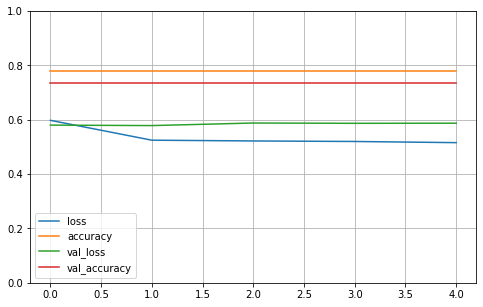

Compute valiation accuracy
2023-01-03 13:27:32.637253
Range of scores: 0.18492438 to 0.24349983
Predicted zeros and ones 428 0
Accuracy: 73.60% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:27:32.798836
Fold 5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[ 14  53 211 ...   0   0   0]
Train sizes (1593, 1997) (1593, 1)
Valid sizes (293, 1997) (293, 1)
Train set ones/size 393 / 1593
Valid set ones/size 40 / 293
BUILD MODEL
COMPILE
FIT
2023-01-03 13:27:33.098032
Epoch 1/5
50/50 [==============================] - 1s 10ms/step - loss: 0.6092 - accuracy: 0.7533 - val_loss: 0.4233 - val_accuracy: 0.8635
Epoch 2/5
50/50 [==============================] - 0s 8ms/step - loss: 0.5573 - accuracy: 0.7533 - val_loss: 0.4437 - val_accuracy: 0.8635
Epoch 3/5
50/50 [==============================] - 0s 7ms/step - loss: 0.5540 - accuracy: 0.7533 - val_loss: 0.4339 - val_accuracy: 0.8635
Epoch 4/5
50/50 [==============================] - 0s 7ms/step - loss: 0.5497 - accuracy: 0.7533 - val_loss: 0.4403 - val_accuracy: 0.8635
Epoch 5/5
50/50 [==============================] - 0s 7ms/step - loss: 0.5439 - accuracy: 0.7533 - val_loss: 0.4229 - val_accuracy: 0.8635


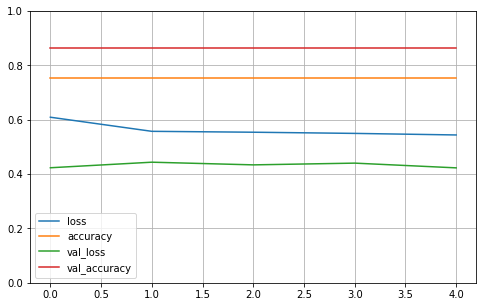

Compute valiation accuracy
2023-01-03 13:27:36.344626
Range of scores: 0.17865159 to 0.3037602
Predicted zeros and ones 293 0
Accuracy: 86.35% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:27:36.493150

Cross validation 5 folds 5 epochs
 accuracy mean 77.01% +/- 8.49
 precision mean 0.00% +/- 0.00
 recall mean 0.00% +/- 0.00
 F1 mean 0.00% +/- 0.00
2023-01-03 13:27:36.493907
-------------
2023-01-03 13:27:36.493964
Cell line for today: 10 = SK.N.DZ
Load RCI values...
Num RCI: 603
Load genes...
2023-01-03 13:27:36.506156
Load sequence...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-01-03 13:27:37.934629
Num IDs: 1976
Count 748 ones out of 1976 labels.
Num counts: 1976
2023-01-03 13:27:37.935151
splitting
Fold 1
Training example
[117 210  72 ...   0   0   0]
Train sizes (1555, 1997) (1555, 1)
Valid sizes (421, 1997) (421, 1)
Train set ones/size 569 / 1555
Valid set ones/size 179 / 421
BUILD MODEL
COMPILE
FIT
2023-01-03 13:27:38.228237
Epoch 1/5
49/49 [==============================] - 1s 10ms/step - loss: 0.6625 - accuracy: 0.6315 - val_loss: 0.7016 - val_accuracy: 0.5748
Epoch 2/5
49/49 [==============================] - 0s 8ms/step - loss: 0.6527 - accuracy: 0.6341 - val_loss: 0.7001 - val_accuracy: 0.5748
Epoch 3/5
49/49 [==============================] - 0s 8ms/step - loss: 0.6476 - accuracy: 0.6341 - val_loss: 0.7132 - val_accuracy: 0.5748
Epoch 4/5
49/49 [==============================] - 0s 7ms/step - loss: 0.6380 - accuracy: 0.6341 - val_loss: 0.7008 - val_accuracy: 0.5748
Epoch 5/5
49/49 [==============================] - 0s 7ms/step - loss: 0.6257 -

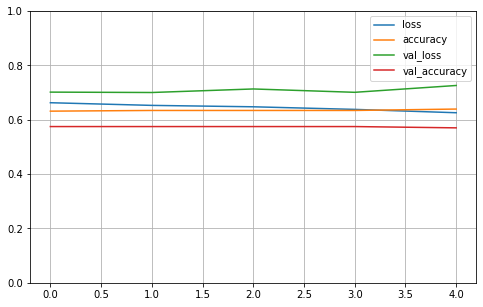

Compute valiation accuracy
2023-01-03 13:27:41.514666
Range of scores: 0.20430854 to 0.55216974
Predicted zeros and ones 415 6
Accuracy: 57.01% Precision: 33.33% Recall: 1.12% F1: 2.16%
2023-01-03 13:27:41.634536
Fold 2
Training example
[117 210  72 ...   0   0   0]
Train sizes (1511, 1997) (1511, 1)
Valid sizes (465, 1997) (465, 1)
Train set ones/size 582 / 1511
Valid set ones/size 166 / 465
BUILD MODEL
COMPILE
FIT
2023-01-03 13:27:41.925745
Epoch 1/5
48/48 [==============================] - 1s 10ms/step - loss: 0.6716 - accuracy: 0.6135 - val_loss: 0.6496 - val_accuracy: 0.6430
Epoch 2/5
48/48 [==============================] - 0s 7ms/step - loss: 0.6644 - accuracy: 0.6148 - val_loss: 0.6494 - val_accuracy: 0.6430
Epoch 3/5
48/48 [==============================] - 0s 8ms/step - loss: 0.6610 - accuracy: 0.6148 - val_loss: 0.6492 - val_accuracy: 0.6430
Epoch 4/5
48/48 [==============================] - 0s 8ms/step - loss: 0.6561 - accuracy: 0.6148 - val_loss: 0.6495 - val_accuracy: 0.6

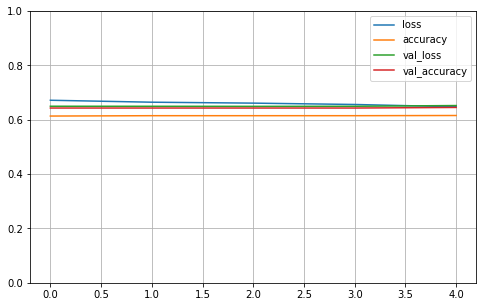

Compute valiation accuracy
2023-01-03 13:27:45.178820
Range of scores: 0.3140339 to 0.5139088
Predicted zeros and ones 458 7
Accuracy: 64.52% Precision: 57.14% Recall: 2.41% F1: 4.62%
2023-01-03 13:27:45.295056
Fold 3
Training example
[ 89  99 140 ...   0   0   0]
Train sizes (1593, 1997) (1593, 1)
Valid sizes (383, 1997) (383, 1)
Train set ones/size 636 / 1593
Valid set ones/size 112 / 383
BUILD MODEL
COMPILE
FIT
2023-01-03 13:27:45.577361
Epoch 1/5
50/50 [==============================] - 1s 11ms/step - loss: 0.6769 - accuracy: 0.5907 - val_loss: 0.6224 - val_accuracy: 0.7076
Epoch 2/5
50/50 [==============================] - 0s 7ms/step - loss: 0.6696 - accuracy: 0.6008 - val_loss: 0.6346 - val_accuracy: 0.7076
Epoch 3/5
50/50 [==============================] - 0s 7ms/step - loss: 0.6655 - accuracy: 0.6008 - val_loss: 0.6230 - val_accuracy: 0.7076
Epoch 4/5
50/50 [==============================] - 0s 8ms/step - loss: 0.6577 - accuracy: 0.6064 - val_loss: 0.6189 - val_accuracy: 0.705

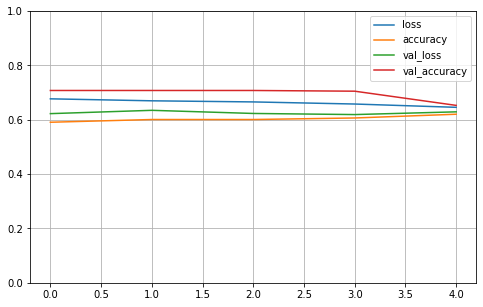

Compute valiation accuracy
2023-01-03 13:27:48.807970
Range of scores: 0.29149762 to 0.5843792
Predicted zeros and ones 338 45
Accuracy: 65.27% Precision: 26.67% Recall: 10.71% F1: 15.29%
2023-01-03 13:27:48.957182
Fold 4
Training example
[117 210  72 ...   0   0   0]
Train sizes (1658, 1997) (1658, 1)
Valid sizes (318, 1997) (318, 1)
Train set ones/size 612 / 1658
Valid set ones/size 136 / 318
BUILD MODEL
COMPILE
FIT
2023-01-03 13:27:49.230351
Epoch 1/5
52/52 [==============================] - 1s 10ms/step - loss: 0.6697 - accuracy: 0.6212 - val_loss: 0.6874 - val_accuracy: 0.5723
Epoch 2/5
52/52 [==============================] - 0s 8ms/step - loss: 0.6549 - accuracy: 0.6309 - val_loss: 0.6885 - val_accuracy: 0.5723
Epoch 3/5
52/52 [==============================] - 0s 7ms/step - loss: 0.6491 - accuracy: 0.6309 - val_loss: 0.6958 - val_accuracy: 0.5723
Epoch 4/5
52/52 [==============================] - 0s 7ms/step - loss: 0.6395 - accuracy: 0.6345 - val_loss: 0.6910 - val_accuracy: 0

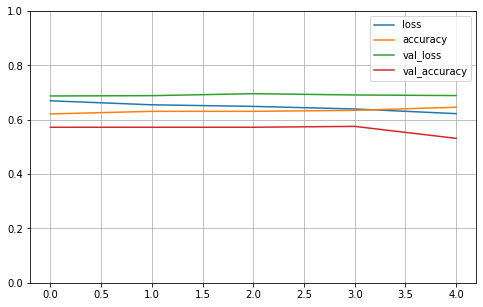

Compute valiation accuracy
2023-01-03 13:27:52.502222
Range of scores: 0.2992856 to 0.64586765
Predicted zeros and ones 263 55
Accuracy: 53.14% Precision: 38.18% Recall: 15.44% F1: 21.99%
2023-01-03 13:27:52.625069
Fold 5
Training example
[117 210  72 ...   0   0   0]
Train sizes (1587, 1997) (1587, 1)
Valid sizes (389, 1997) (389, 1)
Train set ones/size 593 / 1587
Valid set ones/size 155 / 389
BUILD MODEL
COMPILE
FIT
2023-01-03 13:27:52.915287
Epoch 1/5
50/50 [==============================] - 1s 11ms/step - loss: 0.6690 - accuracy: 0.6213 - val_loss: 0.6738 - val_accuracy: 0.6015
Epoch 2/5
50/50 [==============================] - 0s 7ms/step - loss: 0.6597 - accuracy: 0.6263 - val_loss: 0.6696 - val_accuracy: 0.6015
Epoch 3/5
50/50 [==============================] - 0s 7ms/step - loss: 0.6558 - accuracy: 0.6263 - val_loss: 0.6680 - val_accuracy: 0.6015
Epoch 4/5
50/50 [==============================] - 0s 7ms/step - loss: 0.6499 - accuracy: 0.6263 - val_loss: 0.6645 - val_accuracy: 0

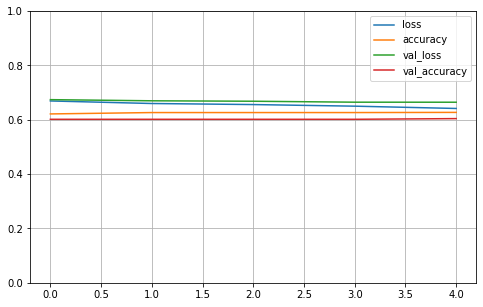

Compute valiation accuracy
2023-01-03 13:27:55.964400
Range of scores: 0.28018916 to 0.5169507
Predicted zeros and ones 388 1
Accuracy: 60.41% Precision: 100.00% Recall: 0.65% F1: 1.28%
2023-01-03 13:27:56.113797

Cross validation 5 folds 5 epochs
 accuracy mean 60.07% +/- 4.57
 precision mean 51.06% +/- 26.48
 recall mean 6.07% +/- 5.95
 F1 mean 9.07% +/- 8.17
2023-01-03 13:27:56.118016
-------------
2023-01-03 13:27:56.118077
Cell line for today: 11 = SK.N.SH
Load RCI values...
Num RCI: 1647
Load genes...
2023-01-03 13:27:56.132939
Load sequence...
2023-01-03 13:27:58.619231
Num IDs: 3565
Count 1107 ones out of 3565 labels.
Num counts: 3565
2023-01-03 13:27:58.619880
splitting
Fold 1
Training example
[211  74  38 ...   0   0   0]
Train sizes (2892, 1997) (2892, 1)
Valid sizes (673, 1997) (673, 1)
Train set ones/size 898 / 2892
Valid set ones/size 209 / 673
BUILD MODEL
COMPILE
FIT
2023-01-03 13:27:59.109824
Epoch 1/5
91/91 [==============================] - 1s 8ms/step - loss: 0.6327 

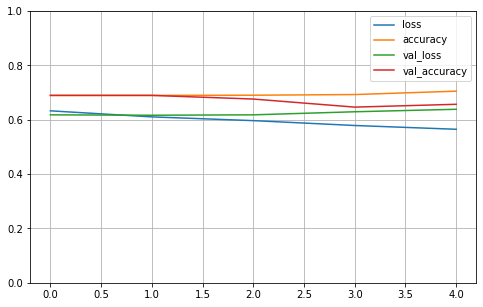

Compute valiation accuracy
2023-01-03 13:28:04.925426
Range of scores: 0.033472106 to 0.8124893
Predicted zeros and ones 589 84
Accuracy: 65.68% Precision: 36.90% Recall: 14.83% F1: 21.16%
2023-01-03 13:28:05.076093
Fold 2
Training example
[211  74  38 ...   0   0   0]
Train sizes (2719, 1997) (2719, 1)
Valid sizes (846, 1997) (846, 1)
Train set ones/size 825 / 2719
Valid set ones/size 282 / 846
BUILD MODEL
COMPILE
FIT
2023-01-03 13:28:05.527455
Epoch 1/5
85/85 [==============================] - 1s 9ms/step - loss: 0.6302 - accuracy: 0.6903 - val_loss: 0.6334 - val_accuracy: 0.6667
Epoch 2/5
85/85 [==============================] - 1s 7ms/step - loss: 0.6048 - accuracy: 0.6966 - val_loss: 0.6260 - val_accuracy: 0.6667
Epoch 3/5
85/85 [==============================] - 1s 7ms/step - loss: 0.5926 - accuracy: 0.6962 - val_loss: 0.6165 - val_accuracy: 0.6678
Epoch 4/5
85/85 [==============================] - 1s 7ms/step - loss: 0.5800 - accuracy: 0.6914 - val_loss: 0.6149 - val_accuracy: 0

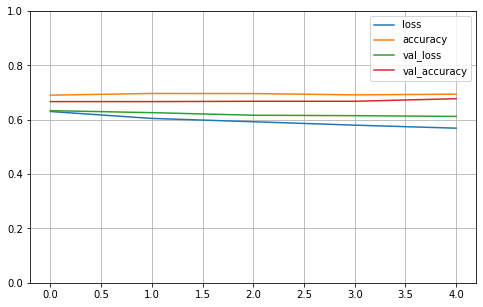

Compute valiation accuracy
2023-01-03 13:28:09.436973
Range of scores: 0.042222507 to 0.7788527
Predicted zeros and ones 807 39
Accuracy: 67.73% Precision: 61.54% Recall: 8.51% F1: 14.95%
2023-01-03 13:28:09.586002
Fold 3
Training example
[211  74  38 ...   0   0   0]
Train sizes (2787, 1997) (2787, 1)
Valid sizes (778, 1997) (778, 1)
Train set ones/size 927 / 2787
Valid set ones/size 180 / 778
BUILD MODEL
COMPILE
FIT
2023-01-03 13:28:10.054326
Epoch 1/5
88/88 [==============================] - 1s 8ms/step - loss: 0.6487 - accuracy: 0.6634 - val_loss: 0.5658 - val_accuracy: 0.7686
Epoch 2/5
88/88 [==============================] - 1s 7ms/step - loss: 0.6283 - accuracy: 0.6674 - val_loss: 0.5548 - val_accuracy: 0.7686
Epoch 3/5
88/88 [==============================] - 1s 6ms/step - loss: 0.6174 - accuracy: 0.6667 - val_loss: 0.5478 - val_accuracy: 0.7686
Epoch 4/5
88/88 [==============================] - 1s 8ms/step - loss: 0.6035 - accuracy: 0.6685 - val_loss: 0.5591 - val_accuracy: 0.

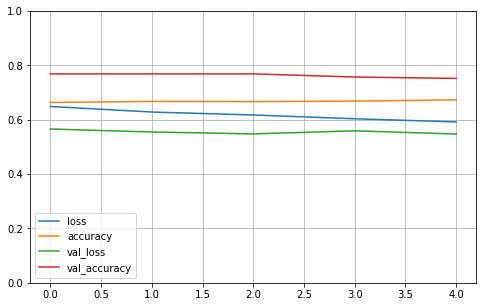

Compute valiation accuracy
2023-01-03 13:28:15.857241
Range of scores: 0.07490056 to 0.72748566
Predicted zeros and ones 715 63
Accuracy: 75.19% Precision: 39.68% Recall: 13.89% F1: 20.58%
2023-01-03 13:28:16.013981
Fold 4
Training example
[ 14  53 211 ...   0   0   0]
Train sizes (2888, 1997) (2888, 1)
Valid sizes (677, 1997) (677, 1)
Train set ones/size 897 / 2888
Valid set ones/size 210 / 677
BUILD MODEL
COMPILE
FIT
2023-01-03 13:28:16.488427
Epoch 1/5
91/91 [==============================] - 1s 9ms/step - loss: 0.6288 - accuracy: 0.6852 - val_loss: 0.6166 - val_accuracy: 0.6898
Epoch 2/5
91/91 [==============================] - 1s 7ms/step - loss: 0.6114 - accuracy: 0.6894 - val_loss: 0.6092 - val_accuracy: 0.6898
Epoch 3/5
91/91 [==============================] - 1s 6ms/step - loss: 0.6011 - accuracy: 0.6891 - val_loss: 0.5990 - val_accuracy: 0.6913
Epoch 4/5
91/91 [==============================] - 1s 7ms/step - loss: 0.5880 - accuracy: 0.6887 - val_loss: 0.5864 - val_accuracy: 0

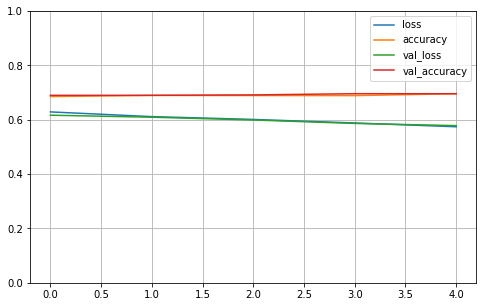

Compute valiation accuracy
2023-01-03 13:28:20.458358
Range of scores: 0.08453513 to 0.71648717
Predicted zeros and ones 647 30
Accuracy: 69.57% Precision: 56.67% Recall: 8.10% F1: 14.17%
2023-01-03 13:28:20.599694
Fold 5
Training example
[211  74  38 ...   0   0   0]
Train sizes (2974, 1997) (2974, 1)
Valid sizes (591, 1997) (591, 1)
Train set ones/size 881 / 2974
Valid set ones/size 226 / 591
BUILD MODEL
COMPILE
FIT
2023-01-03 13:28:21.065746
Epoch 1/5
93/93 [==============================] - 1s 8ms/step - loss: 0.6239 - accuracy: 0.7031 - val_loss: 0.6775 - val_accuracy: 0.6176
Epoch 2/5
93/93 [==============================] - 1s 7ms/step - loss: 0.6016 - accuracy: 0.7038 - val_loss: 0.6856 - val_accuracy: 0.6176
Epoch 3/5
93/93 [==============================] - 1s 7ms/step - loss: 0.5950 - accuracy: 0.7038 - val_loss: 0.6499 - val_accuracy: 0.6176
Epoch 4/5
93/93 [==============================] - 1s 7ms/step - loss: 0.5847 - accuracy: 0.7024 - val_loss: 0.6435 - val_accuracy: 0.

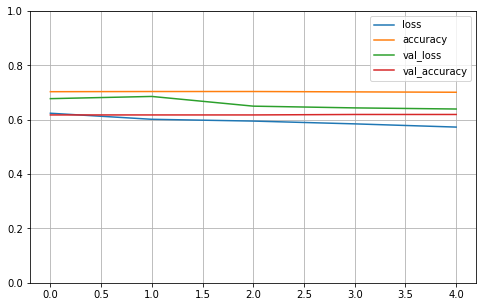

Compute valiation accuracy
2023-01-03 13:28:26.905116
Range of scores: 0.0669112 to 0.621593
Predicted zeros and ones 584 7
Accuracy: 61.93% Precision: 57.14% Recall: 1.77% F1: 3.43%
2023-01-03 13:28:27.035623

Cross validation 5 folds 5 epochs
 accuracy mean 68.02% +/- 4.39
 precision mean 50.39% +/- 10.06
 recall mean 9.42% +/- 4.70
 F1 mean 14.86% +/- 6.38
2023-01-03 13:28:27.036811
-------------
2023-01-03 13:28:27.036882
Cell line for today: 12 = GM12878
Load RCI values...
Num RCI: 1698
Load genes...
2023-01-03 13:28:27.050362
Load sequence...
2023-01-03 13:28:29.436500
Num IDs: 3429
Count 1059 ones out of 3429 labels.
Num counts: 3429
2023-01-03 13:28:29.440842
splitting
Fold 1
Training example
[211  74  38 ...   0   0   0]
Train sizes (2845, 1997) (2845, 1)
Valid sizes (584, 1997) (584, 1)
Train set ones/size 880 / 2845
Valid set ones/size 179 / 584
BUILD MODEL
COMPILE
FIT
2023-01-03 13:28:29.906418
Epoch 1/5
89/89 [==============================] - 1s 9ms/step - loss: 0.6332 - 

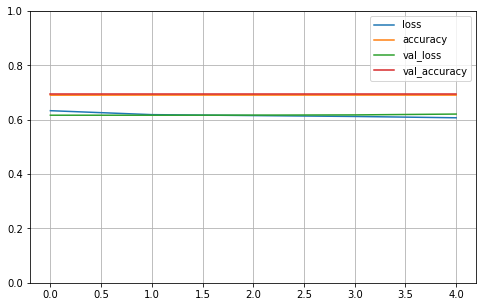

Compute valiation accuracy
2023-01-03 13:28:33.947669
Range of scores: 0.24681616 to 0.3871501
Predicted zeros and ones 584 0
Accuracy: 69.35% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:28:34.113303
Fold 2


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[ 57 228 143 ...   0   0   0]
Train sizes (2739, 1997) (2739, 1)
Valid sizes (690, 1997) (690, 1)
Train set ones/size 852 / 2739
Valid set ones/size 207 / 690
BUILD MODEL
COMPILE
FIT
2023-01-03 13:28:34.574259
Epoch 1/5
86/86 [==============================] - 1s 9ms/step - loss: 0.6353 - accuracy: 0.6827 - val_loss: 0.6163 - val_accuracy: 0.7000
Epoch 2/5
86/86 [==============================] - 1s 7ms/step - loss: 0.6195 - accuracy: 0.6889 - val_loss: 0.6165 - val_accuracy: 0.7000
Epoch 3/5
86/86 [==============================] - 1s 7ms/step - loss: 0.6159 - accuracy: 0.6889 - val_loss: 0.6174 - val_accuracy: 0.7000
Epoch 4/5
86/86 [==============================] - 1s 7ms/step - loss: 0.6109 - accuracy: 0.6889 - val_loss: 0.6250 - val_accuracy: 0.7000
Epoch 5/5
86/86 [==============================] - 1s 7ms/step - loss: 0.5955 - accuracy: 0.6889 - val_loss: 0.6295 - val_accuracy: 0.7000


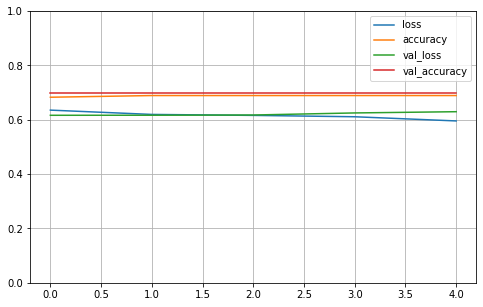

Compute valiation accuracy
2023-01-03 13:28:40.712380
Range of scores: 0.19122203 to 0.46062604
Predicted zeros and ones 690 0
Accuracy: 70.00% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:28:40.867242
Fold 3


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[211  74  38 ...   0   0   0]
Train sizes (2651, 1997) (2651, 1)
Valid sizes (778, 1997) (778, 1)
Train set ones/size 854 / 2651
Valid set ones/size 205 / 778
BUILD MODEL
COMPILE
FIT
2023-01-03 13:28:41.343932
Epoch 1/5
83/83 [==============================] - 1s 10ms/step - loss: 0.6373 - accuracy: 0.6779 - val_loss: 0.5845 - val_accuracy: 0.7365
Epoch 2/5
83/83 [==============================] - 1s 8ms/step - loss: 0.6270 - accuracy: 0.6779 - val_loss: 0.5843 - val_accuracy: 0.7365
Epoch 3/5
83/83 [==============================] - 1s 7ms/step - loss: 0.6250 - accuracy: 0.6779 - val_loss: 0.5802 - val_accuracy: 0.7365
Epoch 4/5
83/83 [==============================] - 1s 8ms/step - loss: 0.6216 - accuracy: 0.6779 - val_loss: 0.5787 - val_accuracy: 0.7365
Epoch 5/5
83/83 [==============================] - 1s 8ms/step - loss: 0.6158 - accuracy: 0.6779 - val_loss: 0.5798 - val_accuracy: 0.7365


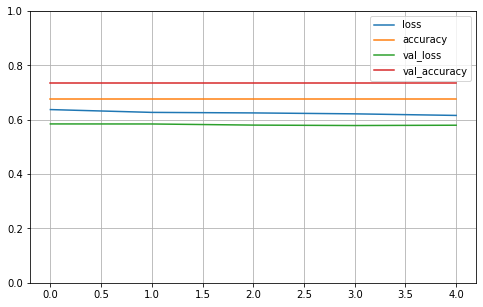

Compute valiation accuracy
2023-01-03 13:28:45.537683
Range of scores: 0.24396496 to 0.3826912
Predicted zeros and ones 778 0
Accuracy: 73.65% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:28:45.713824
Fold 4


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[211  74  38 ...   0   0   0]
Train sizes (2834, 1997) (2834, 1)
Valid sizes (595, 1997) (595, 1)
Train set ones/size 819 / 2834
Valid set ones/size 240 / 595
BUILD MODEL
COMPILE
FIT
2023-01-03 13:28:46.171006
Epoch 1/5
89/89 [==============================] - 1s 8ms/step - loss: 0.6137 - accuracy: 0.7107 - val_loss: 0.7179 - val_accuracy: 0.5966
Epoch 2/5
89/89 [==============================] - 1s 7ms/step - loss: 0.6024 - accuracy: 0.7110 - val_loss: 0.6899 - val_accuracy: 0.5966
Epoch 3/5
89/89 [==============================] - 1s 6ms/step - loss: 0.5973 - accuracy: 0.7110 - val_loss: 0.7011 - val_accuracy: 0.5966
Epoch 4/5
89/89 [==============================] - 1s 7ms/step - loss: 0.5933 - accuracy: 0.7110 - val_loss: 0.7141 - val_accuracy: 0.5966
Epoch 5/5
89/89 [==============================] - 1s 7ms/step - loss: 0.5871 - accuracy: 0.7110 - val_loss: 0.6911 - val_accuracy: 0.5966


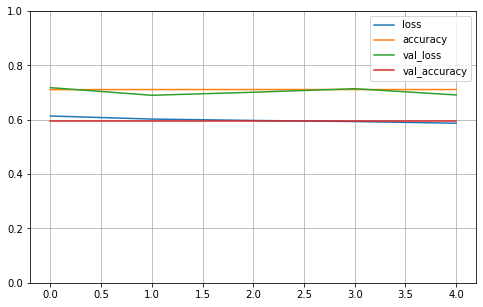

Compute valiation accuracy
2023-01-03 13:28:50.082788
Range of scores: 0.24944183 to 0.39552614
Predicted zeros and ones 595 0
Accuracy: 59.66% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:28:50.247577
Fold 5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[211  74  38 ...   0   0   0]
Train sizes (2647, 1997) (2647, 1)
Valid sizes (782, 1997) (782, 1)
Train set ones/size 831 / 2647
Valid set ones/size 228 / 782
BUILD MODEL
COMPILE
FIT
2023-01-03 13:28:50.696336
Epoch 1/5
83/83 [==============================] - 1s 11ms/step - loss: 0.6405 - accuracy: 0.6849 - val_loss: 0.6055 - val_accuracy: 0.7084
Epoch 2/5
83/83 [==============================] - 1s 7ms/step - loss: 0.6218 - accuracy: 0.6861 - val_loss: 0.6041 - val_accuracy: 0.7084
Epoch 3/5
83/83 [==============================] - 1s 7ms/step - loss: 0.6199 - accuracy: 0.6861 - val_loss: 0.6040 - val_accuracy: 0.7084
Epoch 4/5
83/83 [==============================] - 1s 7ms/step - loss: 0.6184 - accuracy: 0.6861 - val_loss: 0.6054 - val_accuracy: 0.7084
Epoch 5/5
83/83 [==============================] - 1s 7ms/step - loss: 0.6134 - accuracy: 0.6861 - val_loss: 0.6002 - val_accuracy: 0.7084


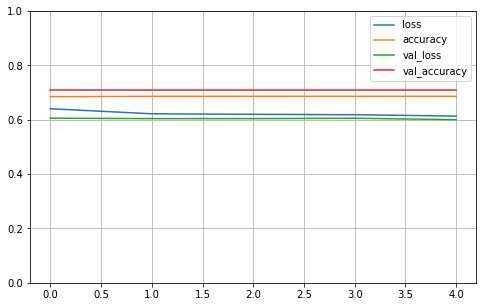

Compute valiation accuracy
2023-01-03 13:28:54.708881
Range of scores: 0.24042442 to 0.32371134
Predicted zeros and ones 782 0
Accuracy: 70.84% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:28:54.947456

Cross validation 5 folds 5 epochs
 accuracy mean 68.70% +/- 4.75
 precision mean 0.00% +/- 0.00
 recall mean 0.00% +/- 0.00
 F1 mean 0.00% +/- 0.00
2023-01-03 13:28:54.948547
-------------
2023-01-03 13:28:54.948607
Cell line for today: 13 = K562
Load RCI values...
Num RCI: 958
Load genes...
2023-01-03 13:28:54.961521
Load sequence...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-01-03 13:28:56.644997
Num IDs: 2307
Count 766 ones out of 2307 labels.
Num counts: 2307
2023-01-03 13:28:56.645488
splitting
Fold 1
Training example
[117 210  72 ...   0   0   0]
Train sizes (1955, 1997) (1955, 1)
Valid sizes (352, 1997) (352, 1)
Train set ones/size 634 / 1955
Valid set ones/size 132 / 352
BUILD MODEL
COMPILE
FIT
2023-01-03 13:28:56.996043
Epoch 1/5
62/62 [==============================] - 1s 10ms/step - loss: 0.6429 - accuracy: 0.6706 - val_loss: 0.6749 - val_accuracy: 0.6250
Epoch 2/5
62/62 [==============================] - 0s 7ms/step - loss: 0.6281 - accuracy: 0.6757 - val_loss: 0.6692 - val_accuracy: 0.6250
Epoch 3/5
62/62 [==============================] - 0s 7ms/step - loss: 0.6258 - accuracy: 0.6757 - val_loss: 0.6820 - val_accuracy: 0.6250
Epoch 4/5
62/62 [==============================] - 0s 7ms/step - loss: 0.6216 - accuracy: 0.6757 - val_loss: 0.6693 - val_accuracy: 0.6250
Epoch 5/5
62/62 [==============================] - 0s 7ms/step - loss: 0.6157 -

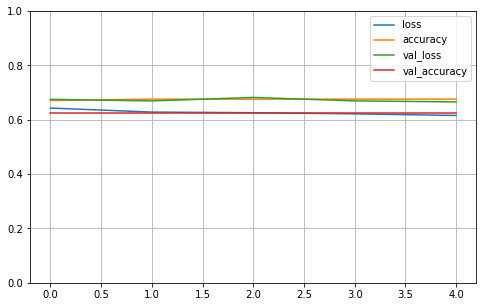

Compute valiation accuracy
2023-01-03 13:29:00.121293
Range of scores: 0.28460902 to 0.42643437
Predicted zeros and ones 352 0
Accuracy: 62.50% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:29:00.273341
Fold 2


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[ 14  53 211 ...   0   0   0]
Train sizes (1703, 1997) (1703, 1)
Valid sizes (604, 1997) (604, 1)
Train set ones/size 588 / 1703
Valid set ones/size 178 / 604
BUILD MODEL
COMPILE
FIT
2023-01-03 13:29:00.593961
Epoch 1/5
54/54 [==============================] - 1s 10ms/step - loss: 0.6550 - accuracy: 0.6547 - val_loss: 0.6072 - val_accuracy: 0.7053
Epoch 2/5
54/54 [==============================] - 0s 7ms/step - loss: 0.6433 - accuracy: 0.6547 - val_loss: 0.6078 - val_accuracy: 0.7053
Epoch 3/5
54/54 [==============================] - 0s 7ms/step - loss: 0.6428 - accuracy: 0.6547 - val_loss: 0.6069 - val_accuracy: 0.7053
Epoch 4/5
54/54 [==============================] - 0s 8ms/step - loss: 0.6380 - accuracy: 0.6547 - val_loss: 0.6086 - val_accuracy: 0.7053
Epoch 5/5
54/54 [==============================] - 0s 8ms/step - loss: 0.6362 - accuracy: 0.6547 - val_loss: 0.6079 - val_accuracy: 0.7053


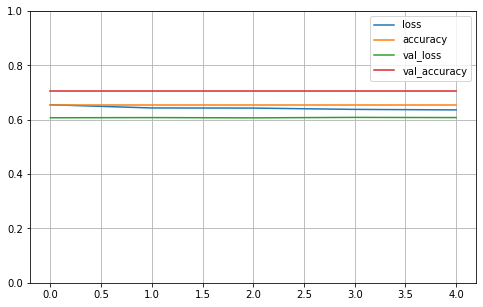

Compute valiation accuracy
2023-01-03 13:29:03.485900
Range of scores: 0.29739705 to 0.39807624
Predicted zeros and ones 604 0
Accuracy: 70.53% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:29:03.660838
Fold 3


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[ 14  53 211 ...   0   0   0]
Train sizes (1854, 1997) (1854, 1)
Valid sizes (453, 1997) (453, 1)
Train set ones/size 592 / 1854
Valid set ones/size 174 / 453
BUILD MODEL
COMPILE
FIT
2023-01-03 13:29:03.988585
Epoch 1/5
58/58 [==============================] - 1s 10ms/step - loss: 0.6389 - accuracy: 0.6802 - val_loss: 0.6792 - val_accuracy: 0.6159
Epoch 2/5
58/58 [==============================] - 0s 7ms/step - loss: 0.6247 - accuracy: 0.6807 - val_loss: 0.6683 - val_accuracy: 0.6159
Epoch 3/5
58/58 [==============================] - 0s 8ms/step - loss: 0.6218 - accuracy: 0.6807 - val_loss: 0.6794 - val_accuracy: 0.6159
Epoch 4/5
58/58 [==============================] - 0s 8ms/step - loss: 0.6192 - accuracy: 0.6807 - val_loss: 0.6759 - val_accuracy: 0.6159
Epoch 5/5
58/58 [==============================] - 0s 7ms/step - loss: 0.6132 - accuracy: 0.6807 - val_loss: 0.6776 - val_accuracy: 0.6159


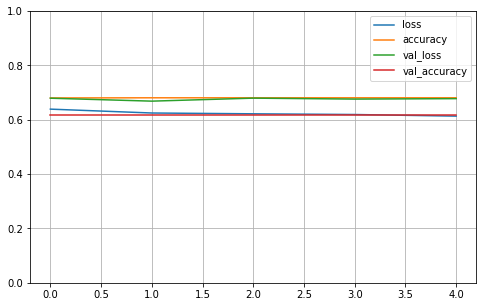

Compute valiation accuracy
2023-01-03 13:29:07.236297
Range of scores: 0.24517816 to 0.37280905
Predicted zeros and ones 453 0
Accuracy: 61.59% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:29:07.389522
Fold 4


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[ 14  53 211 ...   0   0   0]
Train sizes (1900, 1997) (1900, 1)
Valid sizes (407, 1997) (407, 1)
Train set ones/size 581 / 1900
Valid set ones/size 185 / 407
BUILD MODEL
COMPILE
FIT
2023-01-03 13:29:07.713409
Epoch 1/5
60/60 [==============================] - 1s 9ms/step - loss: 0.6335 - accuracy: 0.6942 - val_loss: 0.7510 - val_accuracy: 0.5455
Epoch 2/5
60/60 [==============================] - 0s 7ms/step - loss: 0.6134 - accuracy: 0.6942 - val_loss: 0.7550 - val_accuracy: 0.5455
Epoch 3/5
60/60 [==============================] - 0s 8ms/step - loss: 0.6108 - accuracy: 0.6942 - val_loss: 0.7535 - val_accuracy: 0.5455
Epoch 4/5
60/60 [==============================] - 0s 7ms/step - loss: 0.6074 - accuracy: 0.6942 - val_loss: 0.7526 - val_accuracy: 0.5455
Epoch 5/5
60/60 [==============================] - 0s 7ms/step - loss: 0.6015 - accuracy: 0.6942 - val_loss: 0.7707 - val_accuracy: 0.5455


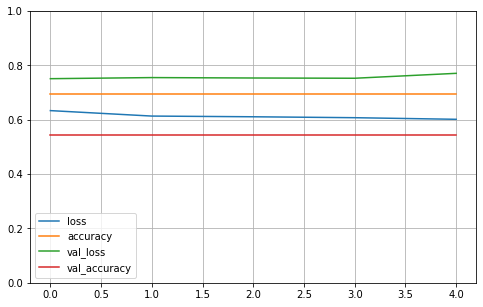

Compute valiation accuracy
2023-01-03 13:29:10.958002
Range of scores: 0.21848178 to 0.37398228
Predicted zeros and ones 407 0
Accuracy: 54.55% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:29:11.078427
Fold 5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[ 14  53 211 ...   0   0   0]
Train sizes (1816, 1997) (1816, 1)
Valid sizes (491, 1997) (491, 1)
Train set ones/size 669 / 1816
Valid set ones/size 97 / 491
BUILD MODEL
COMPILE
FIT
2023-01-03 13:29:11.410479
Epoch 1/5
57/57 [==============================] - 1s 10ms/step - loss: 0.6647 - accuracy: 0.6316 - val_loss: 0.5490 - val_accuracy: 0.8024
Epoch 2/5
57/57 [==============================] - 0s 8ms/step - loss: 0.6575 - accuracy: 0.6316 - val_loss: 0.5653 - val_accuracy: 0.8024
Epoch 3/5
57/57 [==============================] - 0s 7ms/step - loss: 0.6551 - accuracy: 0.6316 - val_loss: 0.5463 - val_accuracy: 0.8024
Epoch 4/5
57/57 [==============================] - 0s 7ms/step - loss: 0.6539 - accuracy: 0.6316 - val_loss: 0.5607 - val_accuracy: 0.8024
Epoch 5/5
57/57 [==============================] - 0s 7ms/step - loss: 0.6486 - accuracy: 0.6316 - val_loss: 0.5763 - val_accuracy: 0.8024


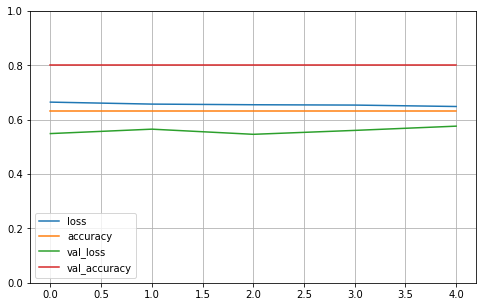

Compute valiation accuracy
2023-01-03 13:29:14.974755
Range of scores: 0.33695248 to 0.43725425
Predicted zeros and ones 491 0
Accuracy: 80.24% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:29:15.133613

Cross validation 5 folds 5 epochs
 accuracy mean 65.88% +/- 8.79
 precision mean 0.00% +/- 0.00
 recall mean 0.00% +/- 0.00
 F1 mean 0.00% +/- 0.00
2023-01-03 13:29:15.135069
-------------
2023-01-03 13:29:15.135108
Cell line for today: 14 = IMR.90
Load RCI values...
Num RCI: 390
Load genes...
2023-01-03 13:29:15.147703
Load sequence...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-01-03 13:29:15.842652
Num IDs: 862
Count 265 ones out of 862 labels.
Num counts: 862
2023-01-03 13:29:15.843094
splitting
Fold 1
Training example
[22 88 94 ...  0  0  0]
Train sizes (685, 1997) (685, 1)
Valid sizes (177, 1997) (177, 1)
Train set ones/size 193 / 685
Valid set ones/size 72 / 177
BUILD MODEL
COMPILE
FIT
2023-01-03 13:29:15.989346
Epoch 1/5
22/22 [==============================] - 1s 14ms/step - loss: 0.6629 - accuracy: 0.6978 - val_loss: 0.6751 - val_accuracy: 0.5932
Epoch 2/5
22/22 [==============================] - 0s 8ms/step - loss: 0.6033 - accuracy: 0.7182 - val_loss: 0.7176 - val_accuracy: 0.5932
Epoch 3/5
22/22 [==============================] - 0s 8ms/step - loss: 0.5927 - accuracy: 0.7182 - val_loss: 0.7147 - val_accuracy: 0.5932
Epoch 4/5
22/22 [==============================] - 0s 8ms/step - loss: 0.5902 - accuracy: 0.7182 - val_loss: 0.7058 - val_accuracy: 0.5932
Epoch 5/5
22/22 [==============================] - 0s 8ms/step - loss: 0.5880 - accuracy: 0.

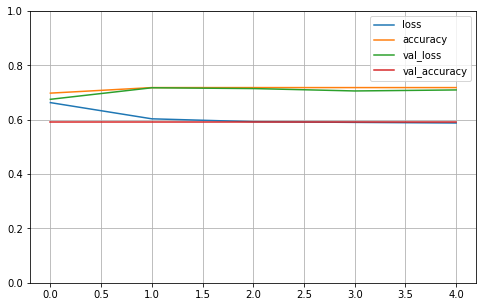

Compute valiation accuracy
2023-01-03 13:29:17.819672
Range of scores: 0.26498565 to 0.3084138
Predicted zeros and ones 177 0
Accuracy: 59.32% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:29:17.936036
Fold 2
Training example
[117 210  72 ...   0   0   0]
Train sizes (651, 1997) (651, 1)
Valid sizes (211, 1997) (211, 1)
Train set ones/size 224 / 651
Valid set ones/size 41 / 211
BUILD MODEL
COMPILE
FIT
2023-01-03 13:29:18.080141
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


21/21 [==============================] - 1s 17ms/step - loss: 0.6787 - accuracy: 0.6513 - val_loss: 0.6287 - val_accuracy: 0.8057
Epoch 2/5
21/21 [==============================] - 0s 8ms/step - loss: 0.6501 - accuracy: 0.6559 - val_loss: 0.5501 - val_accuracy: 0.8057
Epoch 3/5
21/21 [==============================] - 0s 8ms/step - loss: 0.6419 - accuracy: 0.6559 - val_loss: 0.5373 - val_accuracy: 0.8057
Epoch 4/5
21/21 [==============================] - 0s 9ms/step - loss: 0.6402 - accuracy: 0.6559 - val_loss: 0.5430 - val_accuracy: 0.8057
Epoch 5/5
21/21 [==============================] - 0s 9ms/step - loss: 0.6382 - accuracy: 0.6559 - val_loss: 0.5443 - val_accuracy: 0.8057


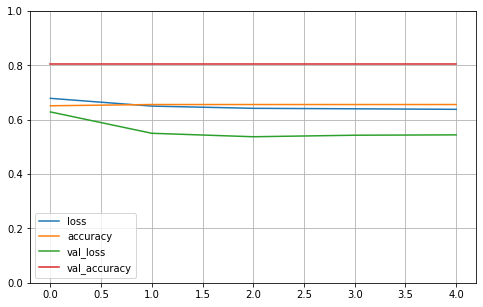

Compute valiation accuracy
2023-01-03 13:29:20.046407
Range of scores: 0.32043397 to 0.35994464
Predicted zeros and ones 211 0
Accuracy: 80.57% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:29:20.156968
Fold 3


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[22 88 94 ...  0  0  0]
Train sizes (705, 1997) (705, 1)
Valid sizes (157, 1997) (157, 1)
Train set ones/size 204 / 705
Valid set ones/size 61 / 157
BUILD MODEL
COMPILE
FIT
2023-01-03 13:29:20.306353
Epoch 1/5
23/23 [==============================] - 1s 14ms/step - loss: 0.6666 - accuracy: 0.6894 - val_loss: 0.6695 - val_accuracy: 0.6115
Epoch 2/5
23/23 [==============================] - 0s 9ms/step - loss: 0.6204 - accuracy: 0.7106 - val_loss: 0.6763 - val_accuracy: 0.6115
Epoch 3/5
23/23 [==============================] - 0s 8ms/step - loss: 0.6015 - accuracy: 0.7106 - val_loss: 0.7008 - val_accuracy: 0.6115
Epoch 4/5
23/23 [==============================] - 0s 8ms/step - loss: 0.6009 - accuracy: 0.7106 - val_loss: 0.6785 - val_accuracy: 0.6115
Epoch 5/5
23/23 [==============================] - 0s 9ms/step - loss: 0.5980 - accuracy: 0.7106 - val_loss: 0.6823 - val_accuracy: 0.6115


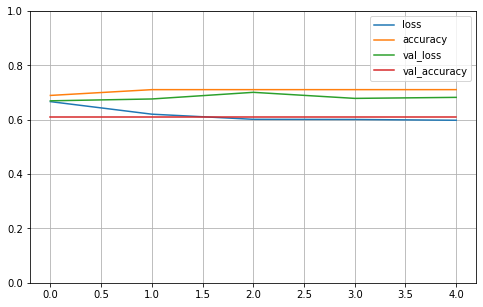

Compute valiation accuracy
2023-01-03 13:29:22.273946
Range of scores: 0.29663536 to 0.31967622
Predicted zeros and ones 157 0
Accuracy: 61.15% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:29:22.384774
Fold 4
Training example
[22 88 94 ...  0  0  0]
Train sizes (692, 1997) (692, 1)
Valid sizes (170, 1997) (170, 1)
Train set ones/size 224 / 692
Valid set ones/size 41 / 170
BUILD MODEL
COMPILE
FIT
2023-01-03 13:29:22.545475
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


22/22 [==============================] - 1s 16ms/step - loss: 0.6684 - accuracy: 0.6749 - val_loss: 0.6119 - val_accuracy: 0.7588
Epoch 2/5
22/22 [==============================] - 0s 8ms/step - loss: 0.6325 - accuracy: 0.6763 - val_loss: 0.5662 - val_accuracy: 0.7588
Epoch 3/5
22/22 [==============================] - 0s 8ms/step - loss: 0.6280 - accuracy: 0.6763 - val_loss: 0.5666 - val_accuracy: 0.7588
Epoch 4/5
22/22 [==============================] - 0s 9ms/step - loss: 0.6243 - accuracy: 0.6763 - val_loss: 0.5670 - val_accuracy: 0.7588
Epoch 5/5
22/22 [==============================] - 0s 8ms/step - loss: 0.6214 - accuracy: 0.6763 - val_loss: 0.5690 - val_accuracy: 0.7588


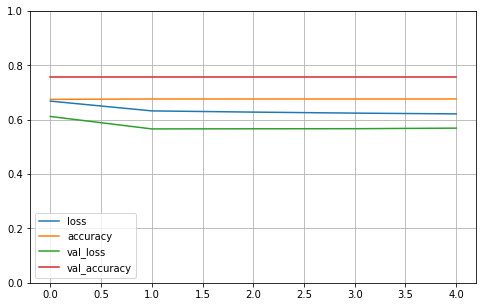

Compute valiation accuracy
2023-01-03 13:29:24.537419
Range of scores: 0.30125087 to 0.35845673
Predicted zeros and ones 170 0
Accuracy: 75.88% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:29:24.643100
Fold 5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[22 88 94 ...  0  0  0]
Train sizes (715, 1997) (715, 1)
Valid sizes (147, 1997) (147, 1)
Train set ones/size 215 / 715
Valid set ones/size 50 / 147
BUILD MODEL
COMPILE
FIT
2023-01-03 13:29:24.801682
Epoch 1/5
23/23 [==============================] - 1s 14ms/step - loss: 0.6627 - accuracy: 0.6993 - val_loss: 0.6492 - val_accuracy: 0.6599
Epoch 2/5
23/23 [==============================] - 0s 8ms/step - loss: 0.6124 - accuracy: 0.6993 - val_loss: 0.6509 - val_accuracy: 0.6599
Epoch 3/5
23/23 [==============================] - 0s 8ms/step - loss: 0.6106 - accuracy: 0.6993 - val_loss: 0.6465 - val_accuracy: 0.6599
Epoch 4/5
23/23 [==============================] - 0s 9ms/step - loss: 0.6067 - accuracy: 0.6993 - val_loss: 0.6477 - val_accuracy: 0.6599
Epoch 5/5
23/23 [==============================] - 0s 9ms/step - loss: 0.6049 - accuracy: 0.6993 - val_loss: 0.6443 - val_accuracy: 0.6599


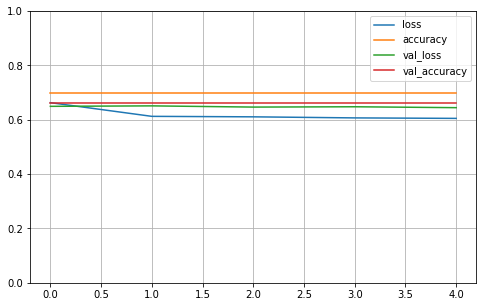

Compute valiation accuracy
2023-01-03 13:29:26.706886
Range of scores: 0.29256073 to 0.34907585
Predicted zeros and ones 147 0
Accuracy: 65.99% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:29:26.823609

Cross validation 5 folds 5 epochs
 accuracy mean 68.58% +/- 8.30
 precision mean 0.00% +/- 0.00
 recall mean 0.00% +/- 0.00
 F1 mean 0.00% +/- 0.00
2023-01-03 13:29:26.824325


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
for CELL_LINE_NUMBER in range(15):
    print('-------------')
    print(datetime.now())
    cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
    print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)
    print("Load RCI values...")
    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE
    gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
    print('Num RCI:', len(gene_to_rci.keys()))
    #print('Example RCI:', list(gene_to_rci.items())[:3])
    print("Load genes...")
    all_genes = list(gene_to_rci.keys())
    print(datetime.now())
    print('Load sequence...')
    filepath = DATA_DIR+SEQUENCE_FILE
    labels,allids,allseq = loader.load_sequence(filepath)
    loader = None  # drop K-mer cache to save RAM
    print(datetime.now())
    print('Num IDs:',len(allids))
    #print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
    print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
    #print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
    print('Num counts:',len(allseq))
    #print('Example sequence:',allseq[3])
    cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
    cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
    print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
    print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
    print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
    print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
    print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
    print(datetime.now())